# Entendimiento de datos

In [1]:
!pip list 

Package                 Version
----------------------- -----------
asttokens               3.0.0
colorama                0.4.6
comm                    0.2.2
contourpy               1.3.1
cycler                  0.12.1
debugpy                 1.8.11
decorator               5.2.1
et_xmlfile              2.0.0
exceptiongroup          1.2.2
executing               2.1.0
fonttools               4.57.0
importlib_metadata      8.6.1
ipykernel               6.29.5
ipython                 9.1.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
joblib                  1.4.2
jupyter_client          8.6.3
jupyter_core            5.7.2
kiwisolver              1.4.8
matplotlib              3.9.2
matplotlib-inline       0.1.7
mkl_fft                 1.3.11
mkl_random              1.2.8
mkl-service             2.4.0
nest_asyncio            1.6.0
numpy                   2.0.1
openpyxl                3.1.5
packaging               24.2
pandas                  2.2.2
parso                   0.8

Conjunto de datos utlizado: [CICIDS2017](https://www.unb.ca/cic/datasets/ids-2017.html)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
seed=9603
proporcion_muestra = 0.0624811224473575 
carpetas = (
    "MachineLearningCVE",
    "TrafficLabelling"
)
archivos_csv = (
    "monday",
    "tuesday",
    "wednesday",
    "thursday_morning_webattacks",
    "thursday_afternoon_infilteration",
    "friday_morning",
    "friday_afternoon_portscan",
    "friday_afternoon_ddos",
)
archivos_output = (
    "output/ids_dataset.csv",
    "../3_preparacion_de_datos/DB/ids_dataset.csv"
)

## Recopilación de datos iniciales - Carga de datos

In [6]:
# Cargando datos
df = pd.concat(
    [pd.read_csv(f"DB/{carpetas[0]}/{i}.csv", sep=",") for i in archivos_csv],
    ignore_index=True
)

print("Datos cargados")

Datos cargados


In [7]:
# Guardar en carpeta output
for i in archivos_output : 
  df.to_csv(i, index=False)
print("Guardado")

KeyboardInterrupt: 

Para agilizar el análisis, en principio, transformaremos las columnas del dataframe y las etiquetas de la columna label a un formato más fácil de recordar y digitar

In [8]:
# Transformación de nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)
print(f"Total de características: {len(df.columns)}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [9]:
# Transformación de nombres de etiquetas de la columna label
df["label"] = df["label"].str.upper().str.replace("� ", "").str.replace(" ", "_").str.replace("-", "_")
print(df["label"].unique())
print(f"Total de etiquetas: {len(df["label"].unique())}")

['BENIGN' 'FTP_PATATOR' 'SSH_PATATOR' 'DOS_SLOWLORIS' 'DOS_SLOWHTTPTEST'
 'DOS_HULK' 'DOS_GOLDENEYE' 'HEARTBLEED' 'WEB_ATTACK_BRUTE_FORCE'
 'WEB_ATTACK_XSS' 'WEB_ATTACK_SQL_INJECTION' 'INFILTRATION' 'BOT'
 'PORTSCAN' 'DDOS']
Total de etiquetas: 15


## Descripción de datos

El conjunto de datos recopilado utilizó un transformador para convertir todo el tráfico de red en segmentos que resumen la comunicación entre máquina destino y máquina de origen de un formato ".pcap" a ".csv". Este transformador es llamado "CICFlowMeter" o "ISCXFlowMeter" y es utilizado por varios estudios que generan bases de datos útiles para realizar proyectos de ciencia de datos y Machine Learning. El transformador fue programado en el lenguaje Java.

Transformador: [CICFlowMeter]()

### 1. Tipos de datos recolectados

|Tipo|Descripción|
|-|-|
|Flujo|Segmento de red dedicado a la comunicación entre un computador y otro|
|packets|Paquetes envíados durante el flujo|
|IAT|Inter-Arrival Time: tiempo entre la llegada de un paquete y el envío de otro|
|active|Tiempo en el que se están intercambiando paquetes, se considera que está activo el flujo|
|Idle|Tiempo de inactividad en un flujo|
|Subflujo|Segmento del flujo principal que puede surgir cuando hay una interrupción, cortes de actividadm timeouts o solicitudes de reconexión|

### 2. Descripción de características

Existen características a las que se puede identificar cierta relación respecto a la descripción de la característica, sin embargo, su principal diferencia es respecto a la dirección de los datos, ya que en un subflujo existe comunicación de origen a destino (Forward) y de destino a origen (Backward), CICFlowMeter recopila características útiles usando este tipo de enfoque.

A continuación, se describen las características en el dataset.

|Forward|Backward|Tipo de característica|Descripción|
|-|-|-|-|
|total Fwd Packet           |total Bwd packets          |Numérica |Total de paquetes envíados durante el flujo en dirección de bwd/fwd      |
|total Length of Fwd Packet |total Length of Bwd Packet |Numérica |Tamaño total de paquete envíado en dirección de bwd/fwd                  |
|Fwd Packet Length Max      |Bwd Packet Length Max      |Numérica |Tamaño máximo de paquete envíado en dirección de bwd/fwd                 |
|Fwd Packet Length Min      |Bwd Packet Length Min      |Numérica |Tamaño mínimo de paquete envíado e dirección de bwd/fwd                  |
|Fwd Packet Length Mean     |Bwd Packet Length Mean     |Numérica |Tamaño medio de paquete envíado e dirección de bwd/fwd                   |
|Fwd Packet Length Std      |Bwd Packet Length Std      |Numérica |Desviación estándar del tamaño de paquete envíado e dirección de bwd/fwd |
|Fwd IAT Total              |Bwd IAT Total              |Numérica |IAT total en dirección de bwd/fwd                                        |
|Fwd IAT Mean               |Bwd IAT Mean               |Numérica |IAT medio en dirección de bwd/fwd                                        |
|Fwd IAT Std                |Bwd IAT Std                |Numérica |Desviación estándar de IAT en dirección de bwd/fwd                       |
|Fwd IAT Max                |Bwd IAT Max                |Numérica |IAT máximo en dirección de bwd/fwd                                       |
|Fwd IAT Min                |Bwd IAT Min                |Numérica |IAT mínimo en dirección de bwd/fwd                                       |
|Fwd PSH flags              |Bwd PSH Flags              |Binaria  |                                                                         |
|Fwd URG Flags              |Bwd URG Flags              |Binaria  |                                                                         |
|Fwd Header Length          |Bwd Header Length          |Numérica |Tamaño total de las cabeceras en bytes en dirección bwd/fwd              |
|FWD Packets/s              |Bwd Packets/s              |Numérica |Números de paquetes por segundo en dirección bwd/fw                      |
|Fwd Segment Size Avg       |Bwd Segment Size Avg       |Numérica |Tamaño promedio de segmentos TCP en el flujo en dirección bwd/fwd        |
|Fwd Bytes/Bulk Avg         |Bwd Bytes/Bulk Avg         |         |                                                                         |
|Fwd Packet/Bulk Avg        |Bwd Packet/Bulk Avg        |         |                                                                         |
|Fwd Bulk Rate Avg          |Bwd Bulk Rate Avg          |         |                                                                         |
|Subflow Fwd Packets        |Subflow Bwd Packets        |Numérica |Número de paquetes enviados en un subflujo de paquete                    |
|Subflow Fwd Bytes          |Subflow Bwd Bytes          |Numérica |Número de bytes enviados en un subflujo de paquetes                      |
|Fwd Init Win bytes         |Bwd Init Win bytes         |Numérica |Respuesta de tamaño en bytes que puede recibir como respuesta            |
|Fwd Act Data Pkts          |                           |Numérica |Recuento de paquetes con mínimo 1 byte de payload de en la dirección fwd |
|Fwd Seg Size Min           |                           |Numérica |Tamaño mínimo de segmento TCP observado en dirección fwd                 |


|Característica|Tipo de característica|Descripción|
|-|-|-|
|Flow Bytes/s           |Numérica |Número de bytes en un flujo por segundo                        |
|Flow Packets/s         |Numérica |Número de paquetes en un flujo por segundo                     |
|Flow IAT Mean          |Numérica |IAT medio dentro de un flujo                                   |
|Flow IAT Std           |Numérica |Desviación estándar del IAT dentro de un flujo                 |
|Flow IAT Max           |Numérica |IAT máximo dentro de un flujo                                  |
|Flow IAT Min           |Numérica |IAT mínimo dentro de un flujo                                  |
|Packet Length Min      |Numérica |Tamaño mínimo de paquetes dentro de un flujo                   |
|Packet Length Max      |Numérica |Tamaño máximo de paquetes dentro de un flujo                   |
|Packet Length Mean     |Numérica |Tamaño medio de paquetes dentro de un flujo                    |
|Packet Length Std      |Numérica |Desviación estándar del tamaño de paquetes dentro de un flujo  |
|Packet Length Variance |Numérica |Varianza del tamaño de paquetes dentro de un flujo             |
|FIN Flag Count         |Binaria  |                                                               |
|SYN Flag Count         |Binaria  |                                                               |
|RST Flag Count         |Binaria  |                                                               |
|PSH Flag Count         |Binaria  |                                                               |
|ACK Flag Count         |Binaria  |                                                               |
|URG Flag Count         |Binaria  |                                                               |
|CWR Flag Count         |Binaria  |                                                               |
|ECE Flag Count         |Binaria  |                                                               |
|down/Up Ratio          |Numérica |Ratio de carga y descarga                                      |
|Average Packet Size    |Numérica |Tamaño promedio de paquetes en un flujo                        |
|Active Mean            |Numérica |Tiempo activo medio                                            |
|Active Std             |Numérica |Desviación estándar del tiempo activo                          |
|Active Max             |Numérica |Máximo tiempo activo                                           |
|Active Min             |Numérica |Mínimo tiempo activo                                           |
|Idle Mean              |Numérica |Idle medio en un flujo                                         |
|Idle Std               |Numérica |Desviación estándar del Idle en un flujo                       |
|Idle Max               |Numérica |Idle máximo en un flujo                                        |
|Idle Min               |Numérica |Idle mínimo en un flujo                                        |
|destination_port       |Nominal  |Puerto de destino                                              |
|label                  |Nominal  |variable objetivo (Tipo de ciberataque)                        |

### 3. Distribución de datos

In [7]:
# Visualización de características y tipo de datos
distribucion = df.shape
print(f"""
N° registros: {distribucion[0]}
N° características: {distribucion[1]}
""")
print(f"""
{df.dtypes.head(40)}
{df.dtypes.tail(40)}
""")


N° registros: 2830743
N° características: 79


destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
total_length_of_bwd_packets      int64
fwd_packet_length_max            int64
fwd_packet_length_min            int64
fwd_packet_length_mean         float64
fwd_packet_length_std          float64
bwd_packet_length_max            int64
bwd_packet_length_min            int64
bwd_packet_length_mean         float64
bwd_packet_length_std          float64
flow_bytes/s                   float64
flow_packets/s                 float64
flow_iat_mean                  float64
flow_iat_std                   float64
flow_iat_max                     int64
flow_iat_min                     int64
fwd_iat_total                    int64
fwd_iat_mean                   float64
fwd_iat_std                    float64
fwd_iat_max                      int64
fwd_iat_min     

## Exploración de datos

### Utilidades

In [8]:
# Función para obtener la distribución de frecuencias de la columna label
def obtenerFrecuencia(df) :
  frecuencia = df["label"].value_counts()
  porcentaje = df["label"].value_counts(normalize=True) * 100

  tabla_frecuencia = pd.DataFrame({
    "Frecuencia": frecuencia,
    "Porcentaje": porcentaje
  })
  
  tabla_frecuencia["Porcentaje"].round(2)
  
  print(tabla_frecuencia)


### 1. Variable objetivo: label

In [10]:
# Tabla de frecuencia de tipos de ciberataques
obtenerFrecuencia(df)

                          Frecuencia  Porcentaje
label                                           
BENIGN                       2273097   80.300366
DOS_HULK                      231073    8.162981
PORTSCAN                      158930    5.614427
DDOS                          128027    4.522735
DOS_GOLDENEYE                  10293    0.363615
FTP_PATATOR                     7938    0.280421
SSH_PATATOR                     5897    0.208320
DOS_SLOWLORIS                   5796    0.204752
DOS_SLOWHTTPTEST                5499    0.194260
BOT                             1966    0.069452
WEB_ATTACK_BRUTE_FORCE          1507    0.053237
WEB_ATTACK_XSS                   652    0.023033
INFILTRATION                      36    0.001272
WEB_ATTACK_SQL_INJECTION          21    0.000742
HEARTBLEED                        11    0.000389


### 2. Distribución de datos

In [2]:
# Se separa en arrays los nombres de las columnas según el tipo de característica
caracteristicas_nominales = ['destination_port', 'label']

caracteristicas_binarias  = [
      'fwd_psh_flags', 'fwd_urg_flags',
      'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 
      'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 
      'cwe_flag_count', 'ece_flag_count'
]
      
caracteristicas_numericas = [
      'flow_duration', 'total_fwd_packets', 'total_backward_packets', 
      'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 
      'fwd_packet_length_max', 'fwd_packet_length_min', 
      'fwd_packet_length_mean', 'fwd_packet_length_std', 
      'bwd_packet_length_max', 'bwd_packet_length_min', 
      'bwd_packet_length_mean', 'bwd_packet_length_std', 
      'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 
      'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 
      'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 
      'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 
      'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
      'min_packet_length', 'max_packet_length', 'packet_length_mean',
      'packet_length_std', 'packet_length_variance', 'down/up_ratio',
      'average_packet_size', 'avg_fwd_segment_size', 
      'avg_bwd_segment_size', 'fwd_header_length.1', 'subflow_fwd_packets', 
      'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes', 
      'init_win_bytes_forward', 'init_win_bytes_backward', 
      'act_data_pkt_fwd', 'min_seg_size_forward', 'active_mean', 
      'active_std', 'active_max', 'active_min', 'idle_mean', 'idle_std', 
      'idle_max', 'idle_min'
]

caracteristicas_no_utiles = [
      'bwd_psh_flags',
      'bwd_urg_flags', 
      'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 
      'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate'
]

caracteristicas_con_valor_maximo_infinito = [
      'flow_bytes/s', 'flow_packets/s'
]

In [3]:
# Características numéricas
for i in caracteristicas_numericas : 
  print(f"""
  Característica: {i}
{df[i].describe()}
""")

NameError: name 'df' is not defined

In [11]:
# Características sin datos para análisis
for i in caracteristicas_no_utiles : 
  print(f"""
  Característica: {i}
{df[i].describe()}
""")


  Característica: bwd_psh_flags
count    2830743.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: bwd_psh_flags, dtype: float64


  Característica: bwd_urg_flags
count    2830743.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: bwd_urg_flags, dtype: float64


  Característica: fwd_avg_bytes/bulk
count    2830743.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: fwd_avg_bytes/bulk, dtype: float64


  Característica: fwd_avg_packets/bulk
count    2830743.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: fwd_avg_packets/bulk, dtype: float64


  Característica: fwd_avg_bulk_rate
count    2830743.0
mean           0.0
std          

In [12]:
# Características con valores máximos en infinito
for i in caracteristicas_con_valor_maximo_infinito : 
  print(f"""
  Característica: {i}
{df[i].describe()}
""")


  Característica: flow_bytes/s
count    2.829385e+06
mean              inf
std               NaN
min     -2.610000e+08
25%      1.193197e+02
50%      4.595549e+03
75%      1.666667e+05
max               inf
Name: flow_bytes/s, dtype: float64


  Característica: flow_packets/s
count    2.830743e+06
mean              inf
std               NaN
min     -2.000000e+06
25%      3.446226e+00
50%      1.106684e+02
75%      2.325581e+04
max               inf
Name: flow_packets/s, dtype: float64



c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


### 3. Visualización de datos

#### 3.1. Boxplots de características numéricas

##### Características numéricas

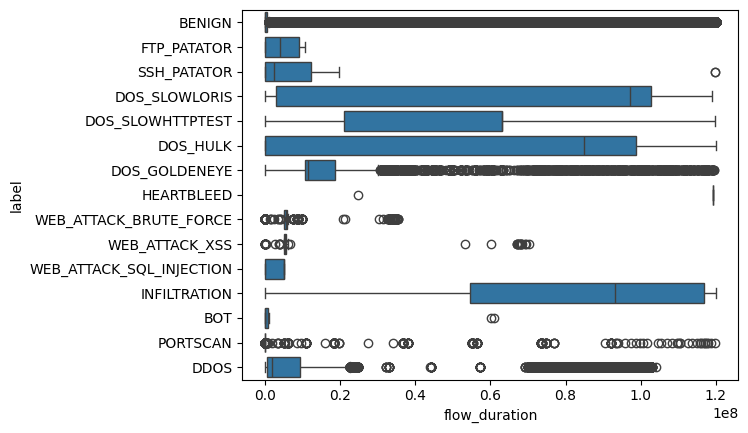

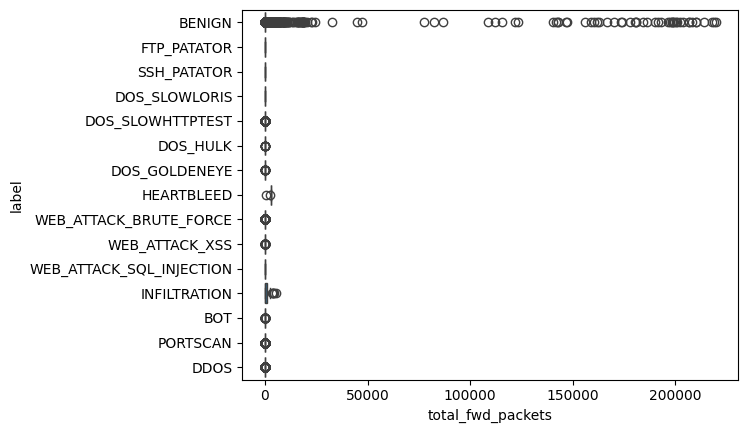

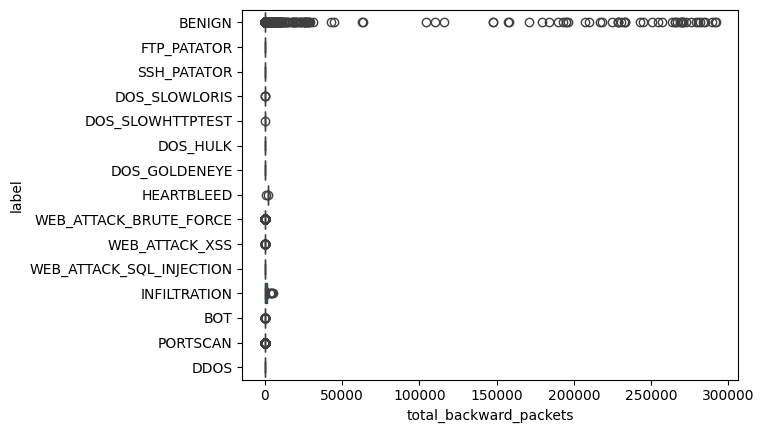

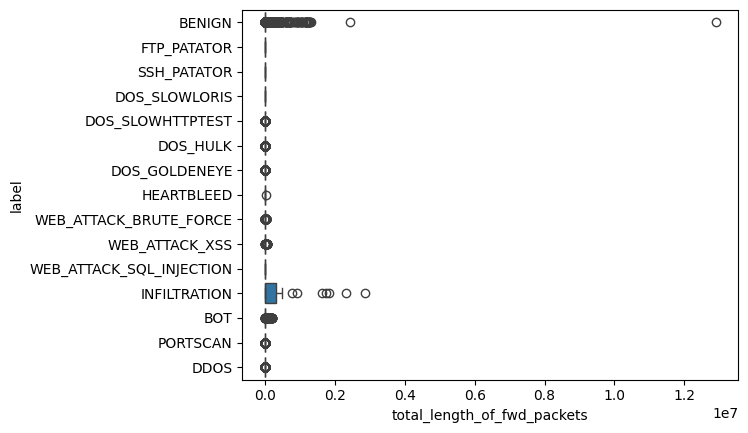

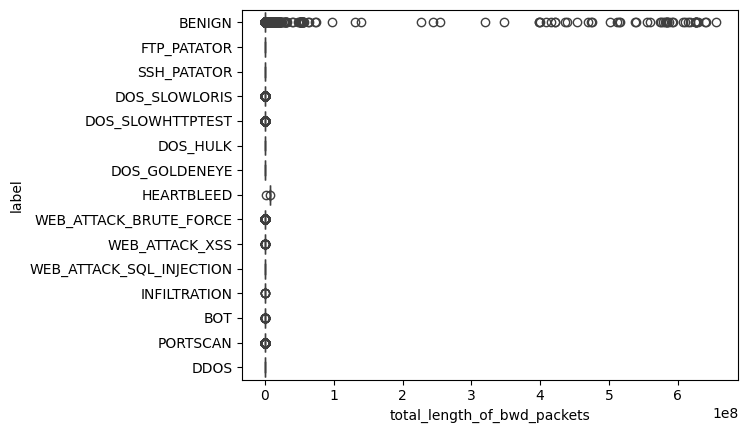

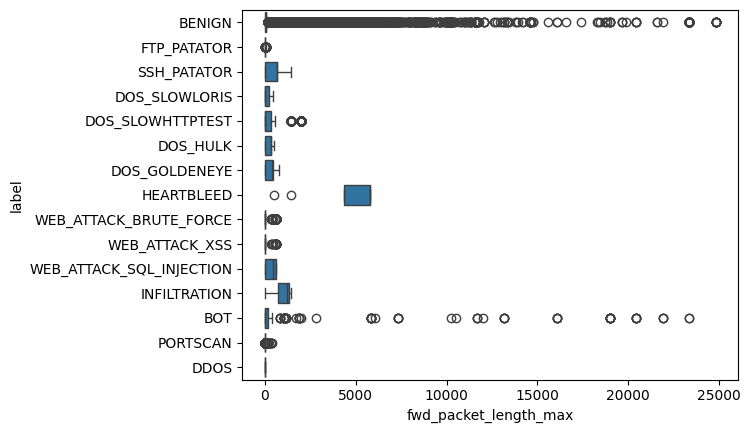

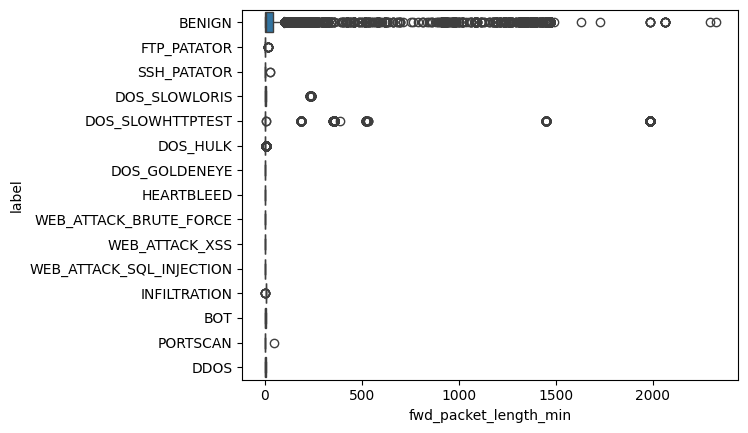

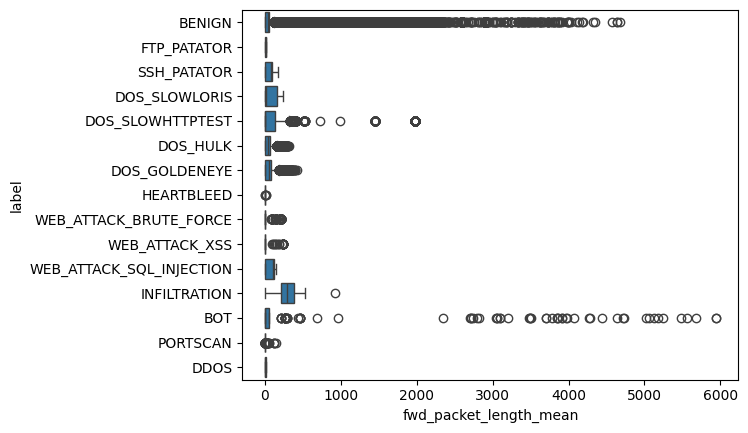

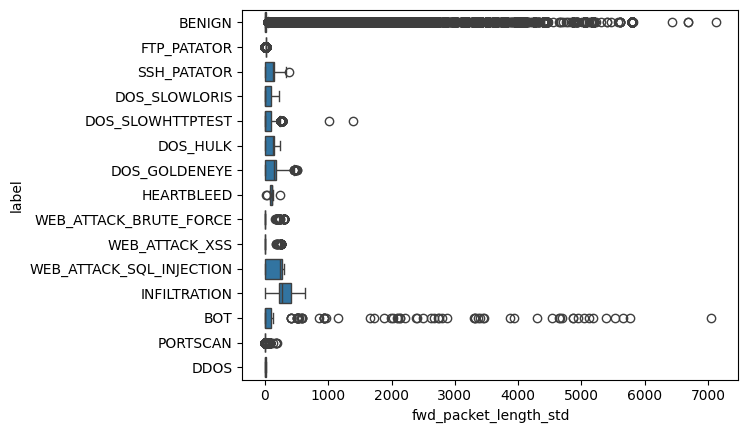

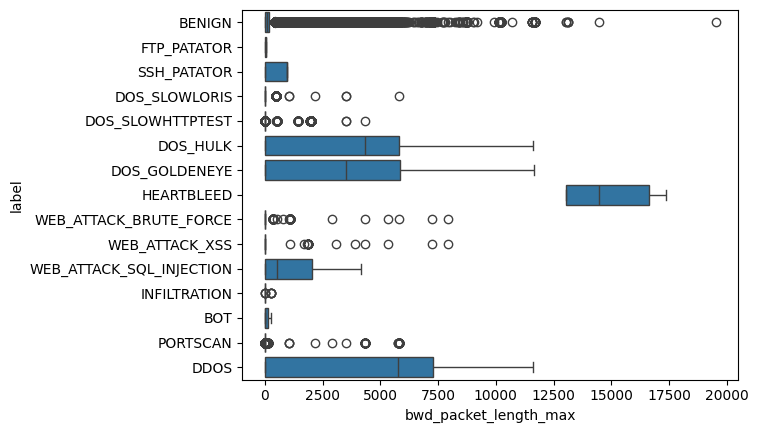

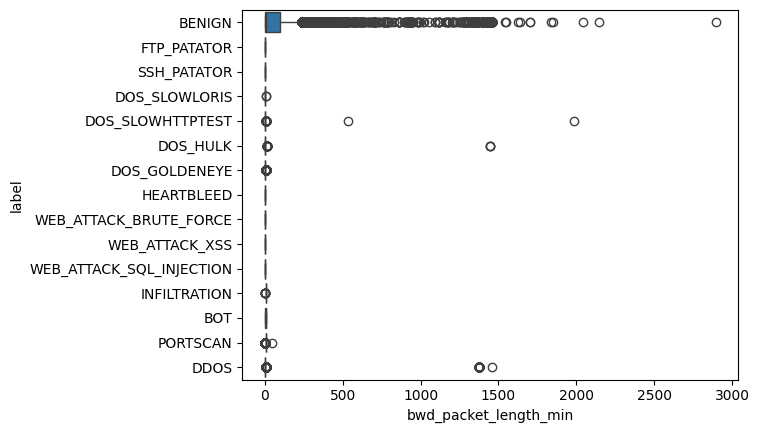

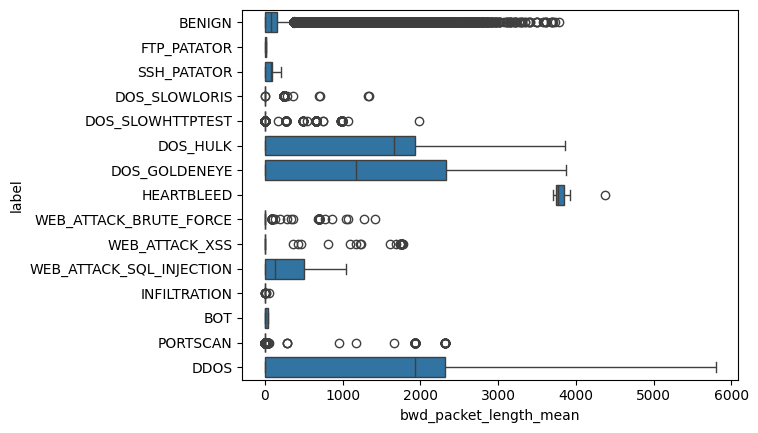

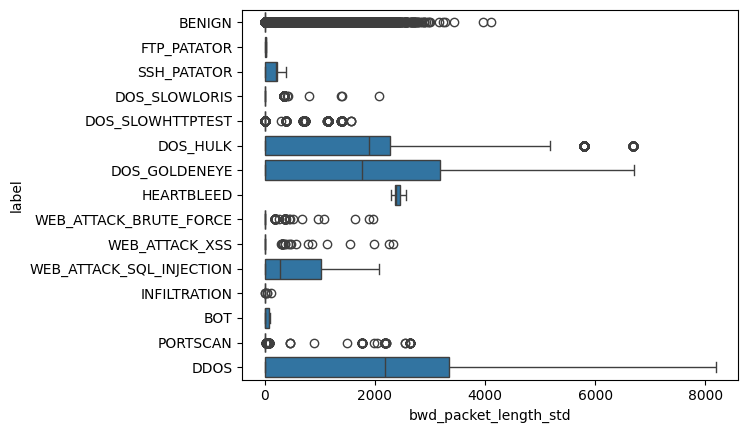

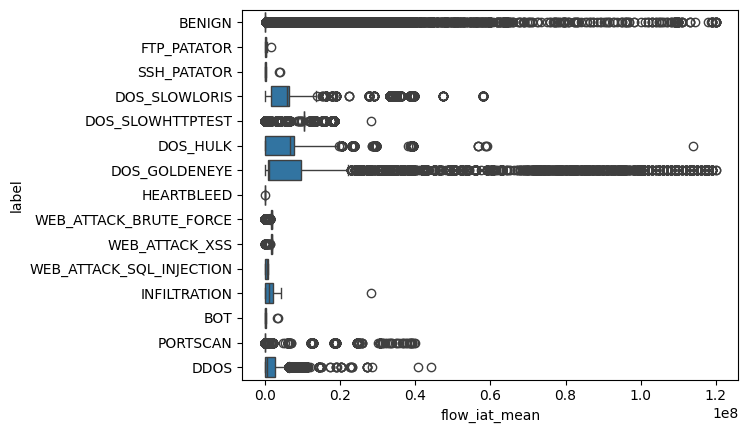

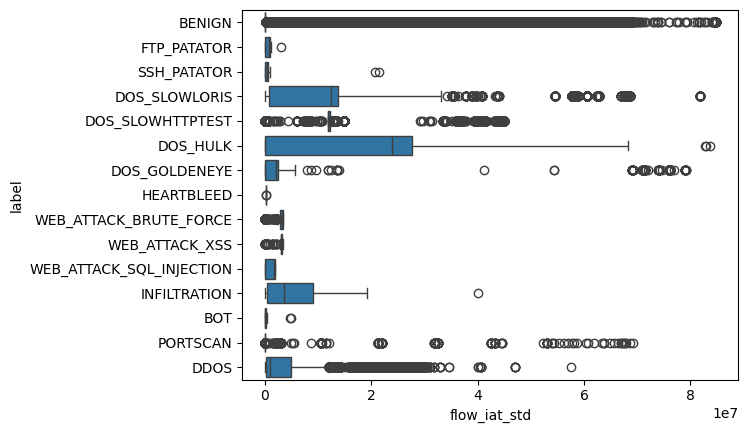

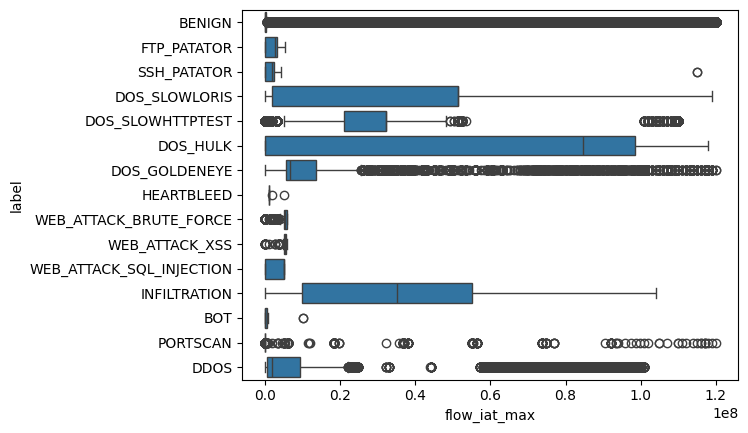

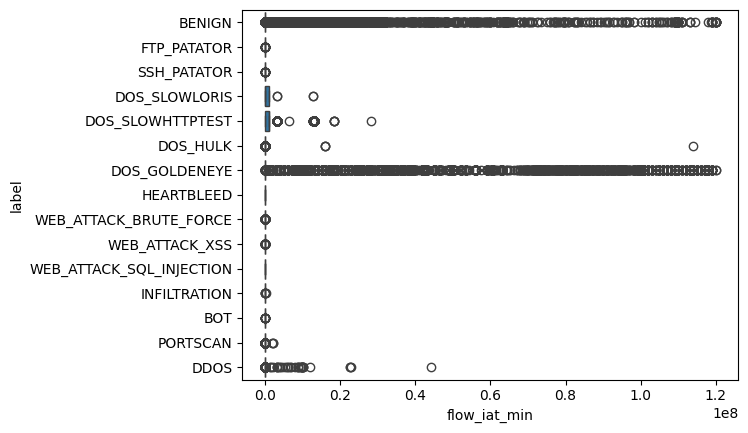

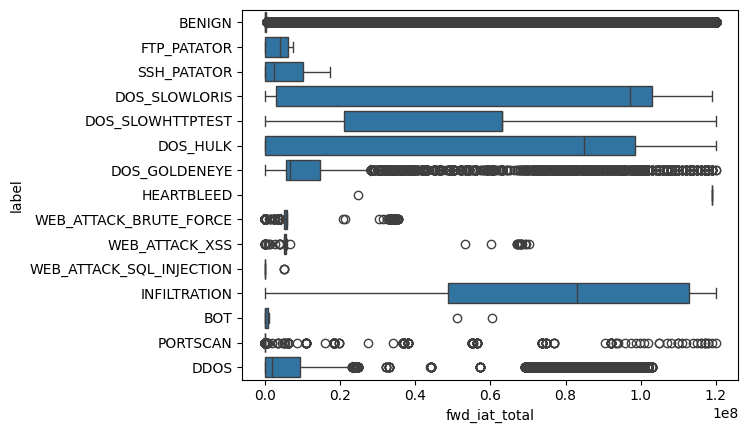

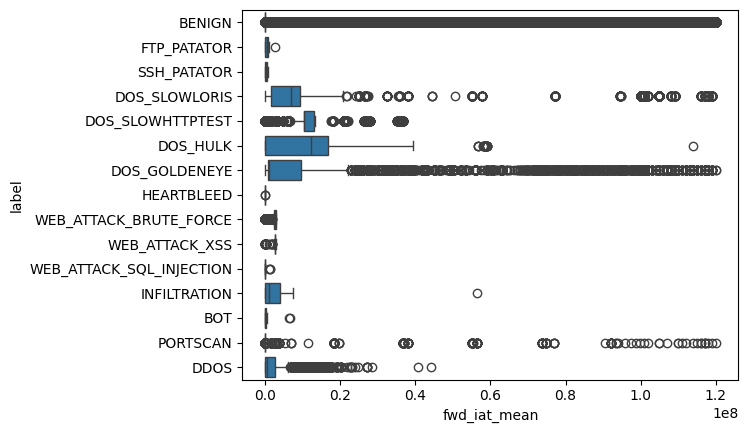

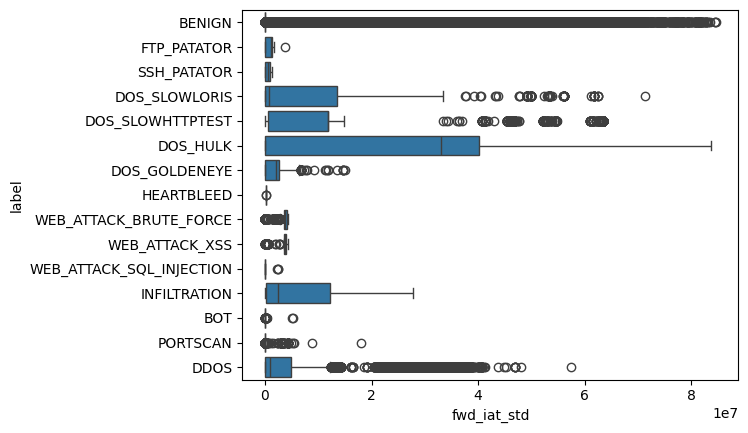

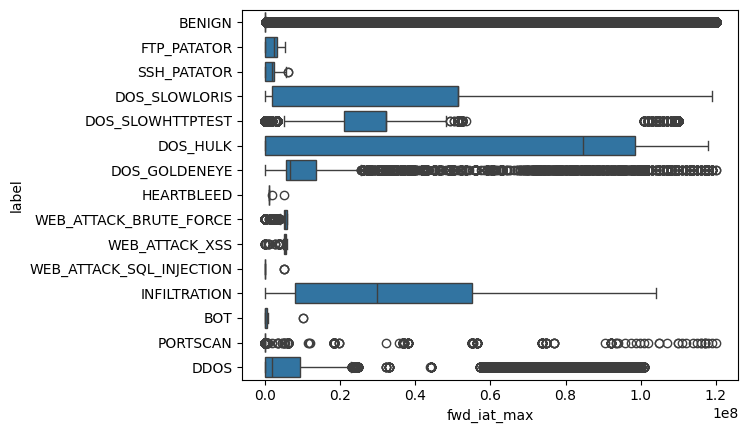

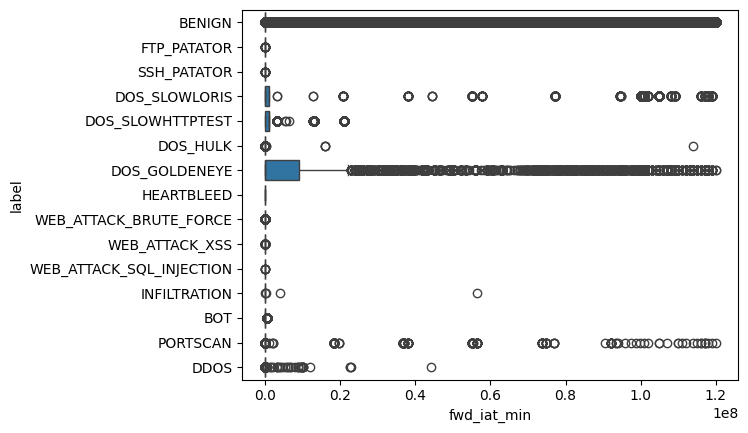

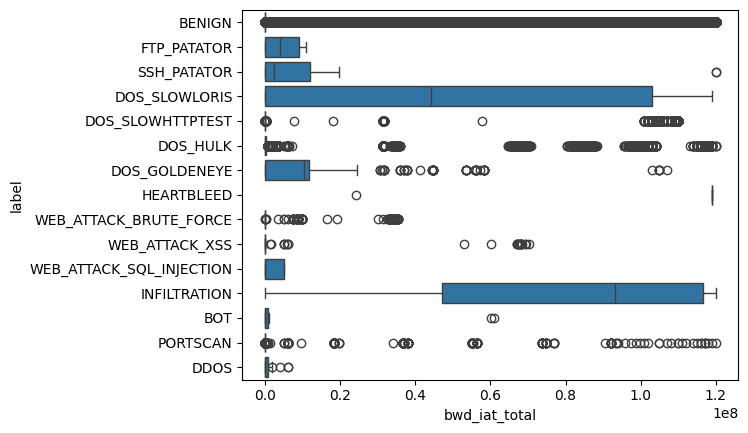

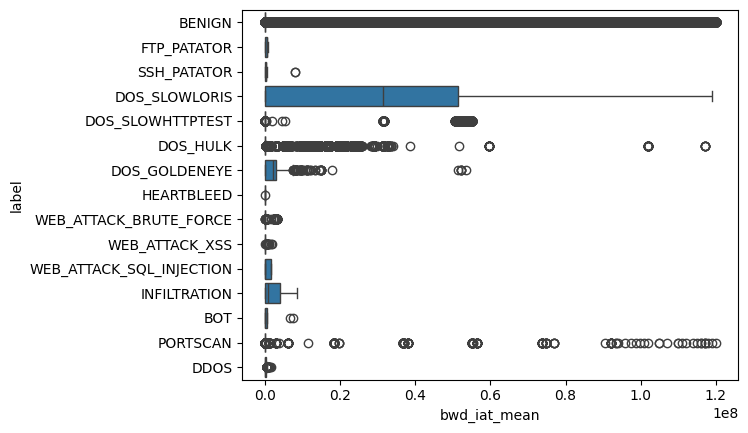

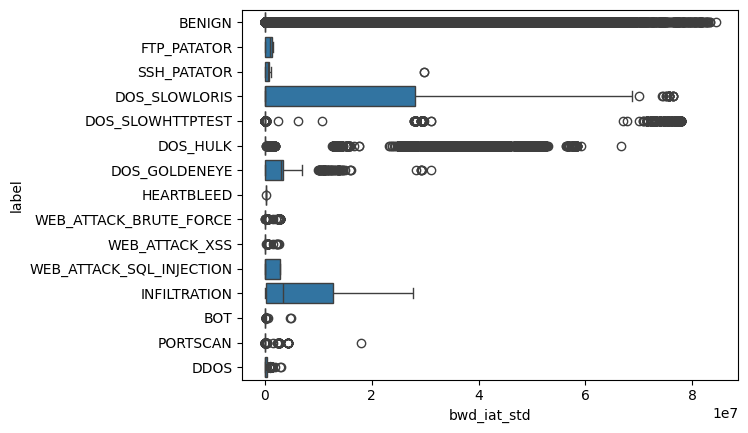

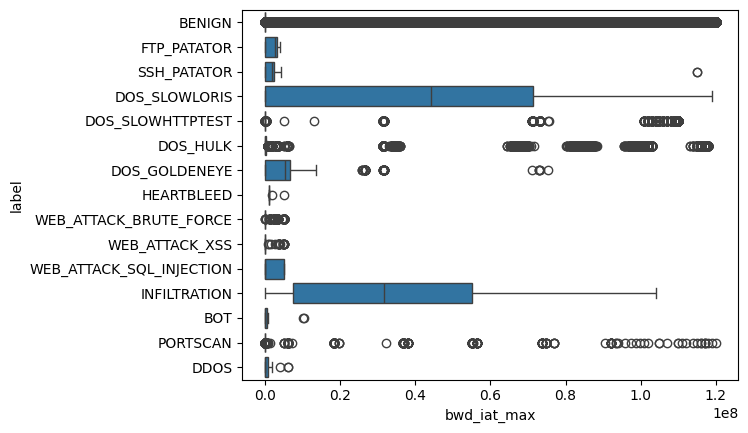

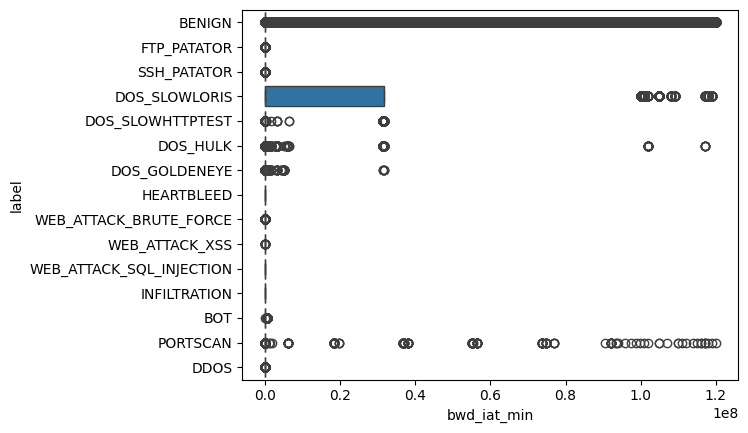

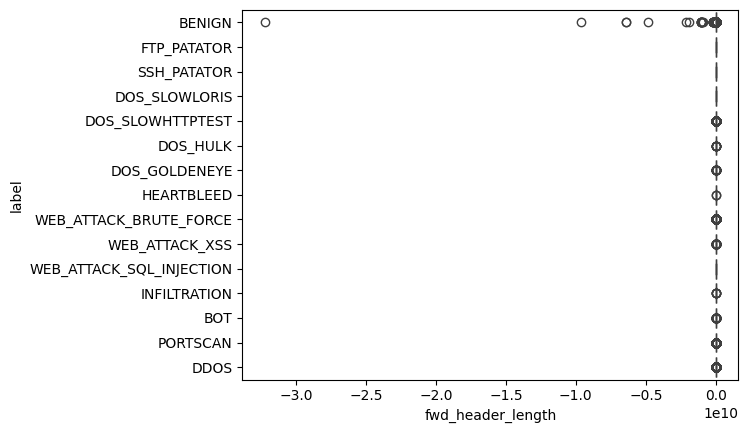

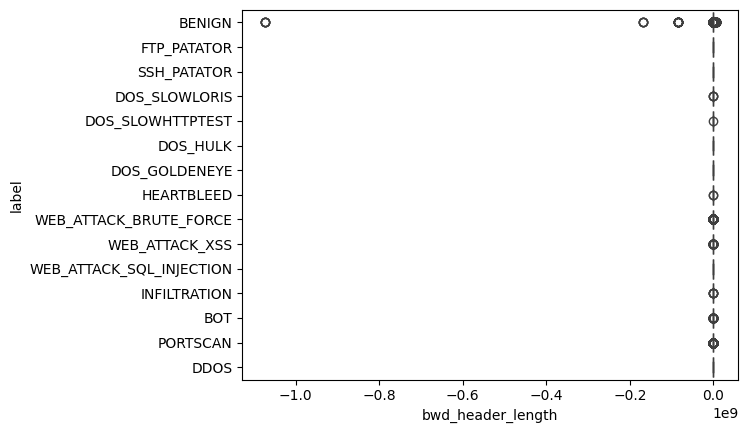

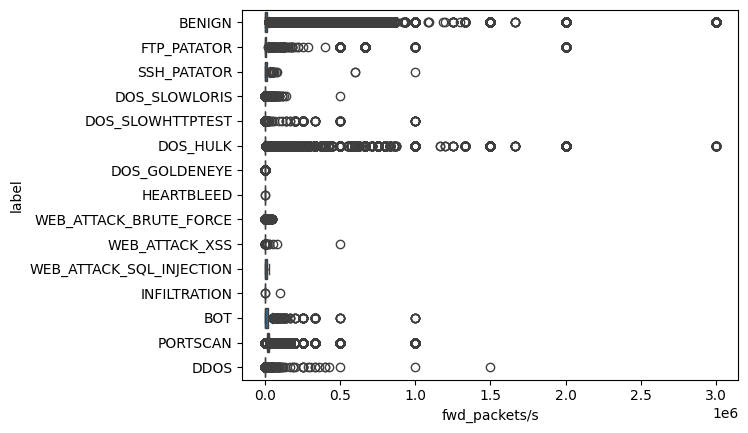

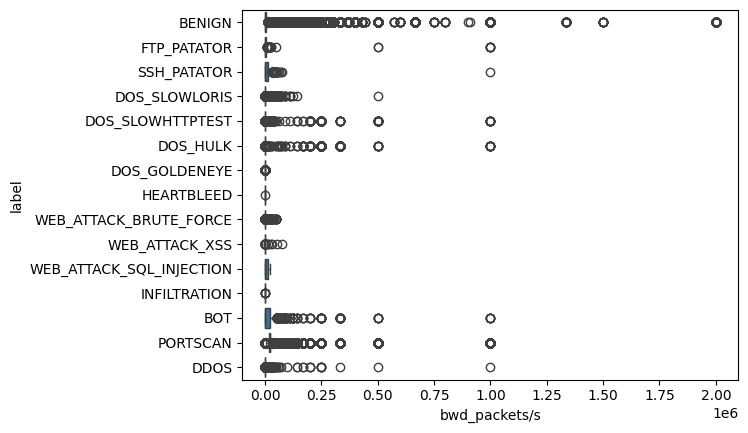

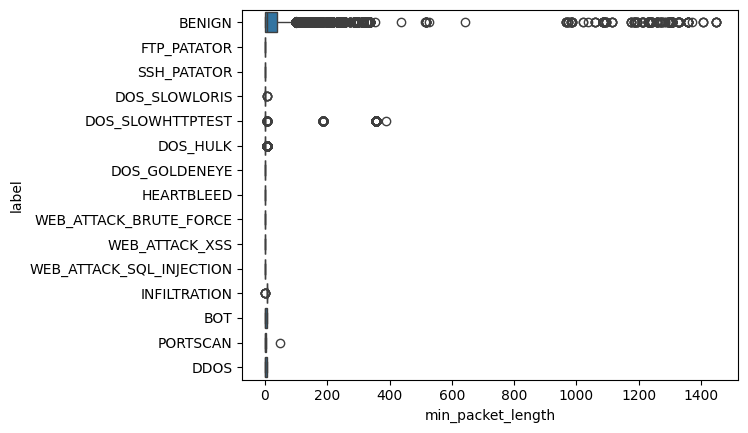

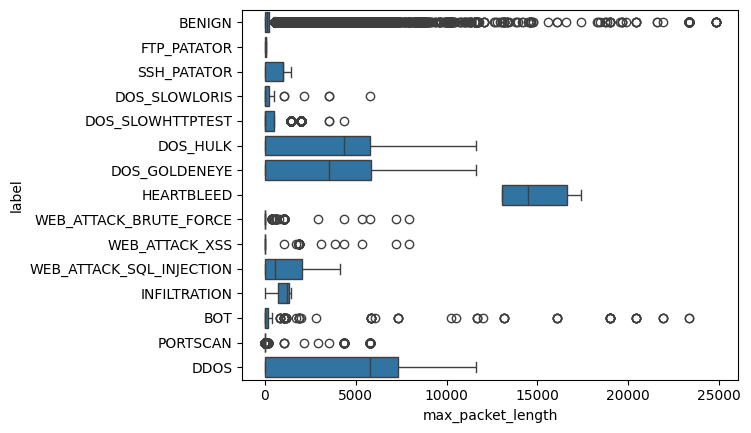

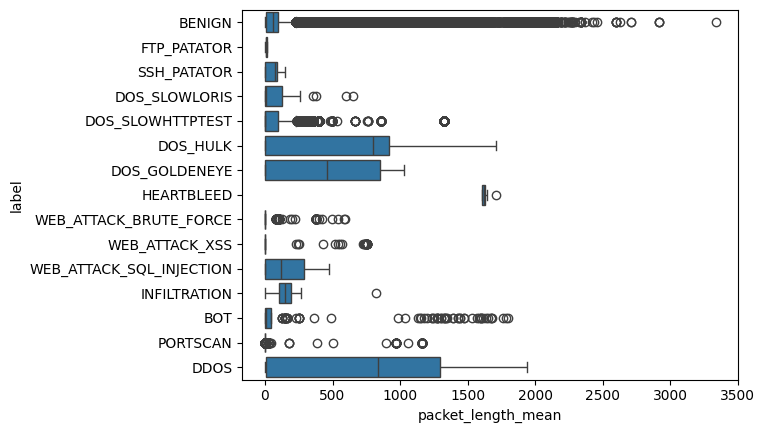

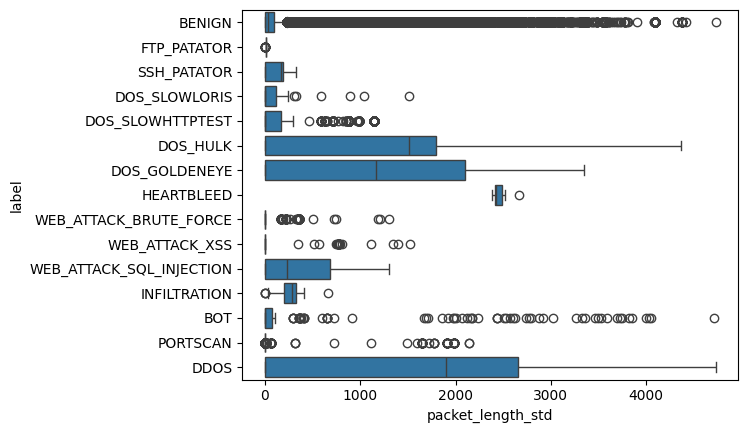

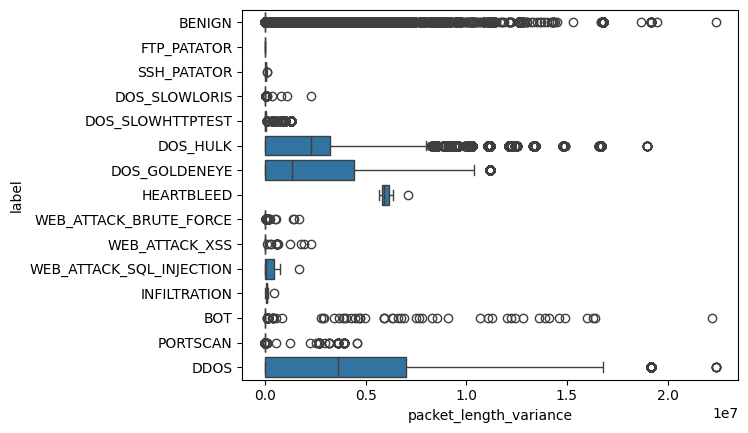

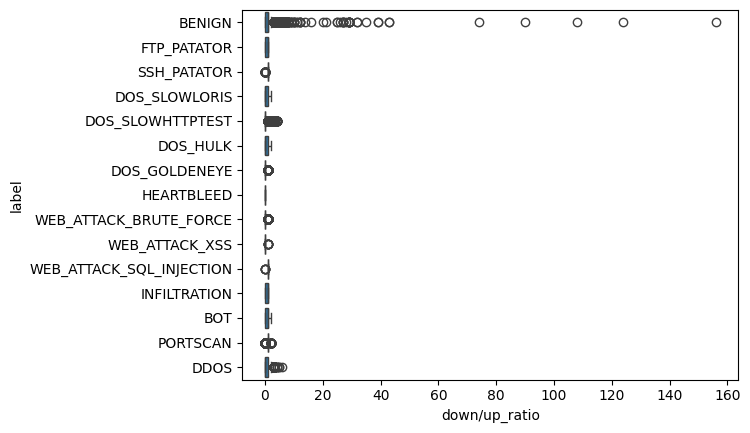

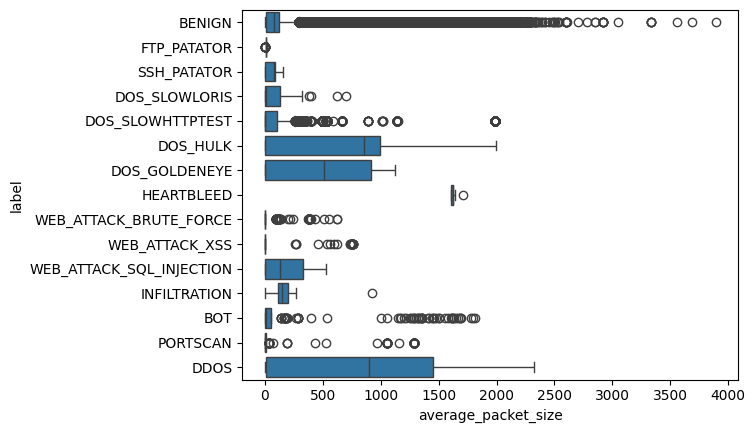

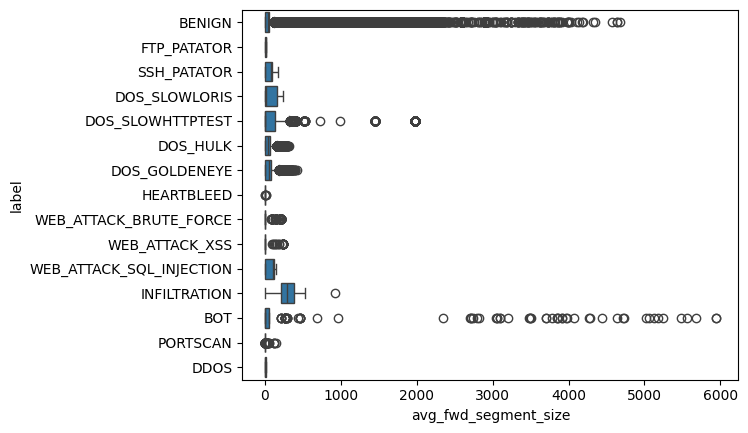

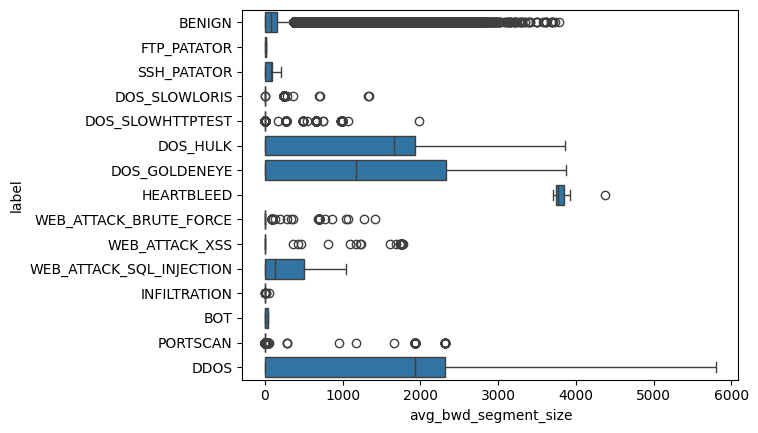

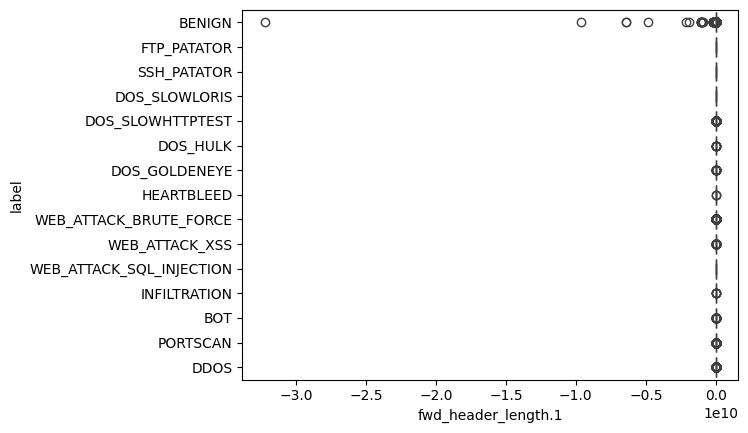

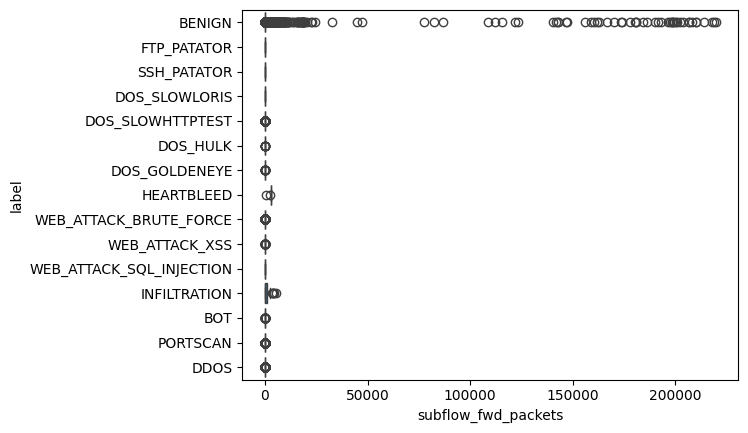

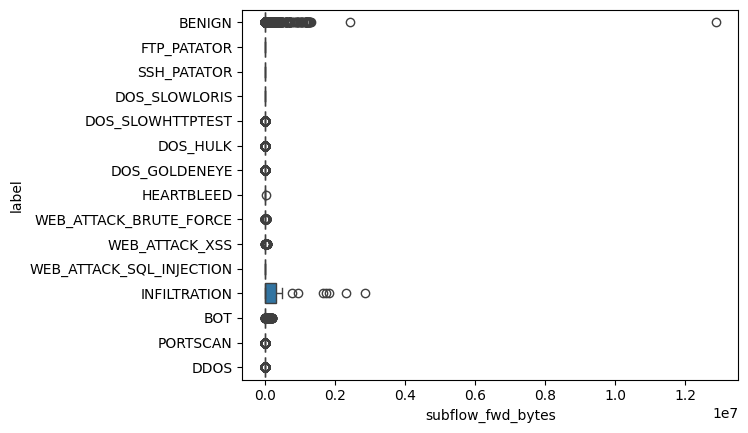

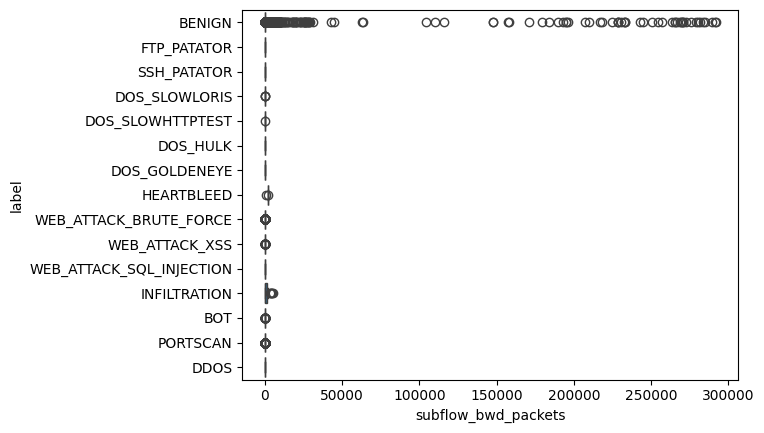

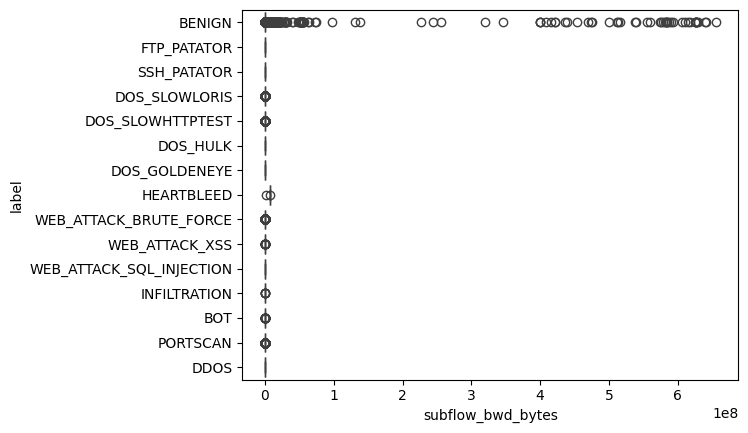

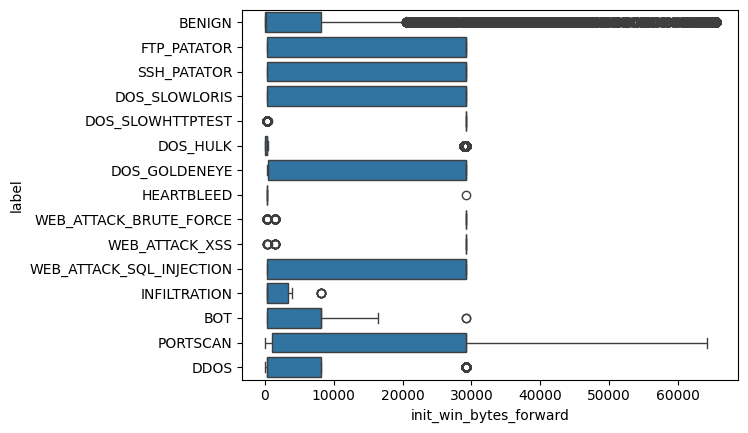

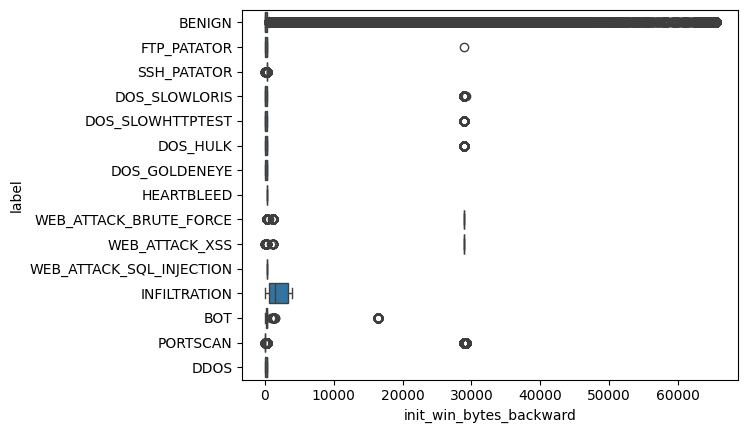

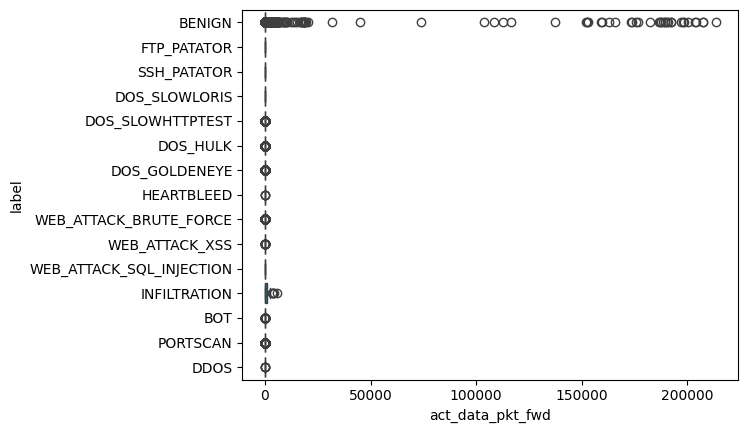

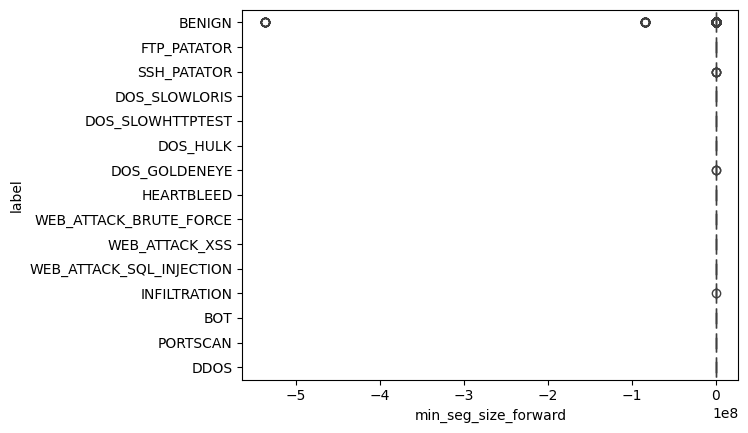

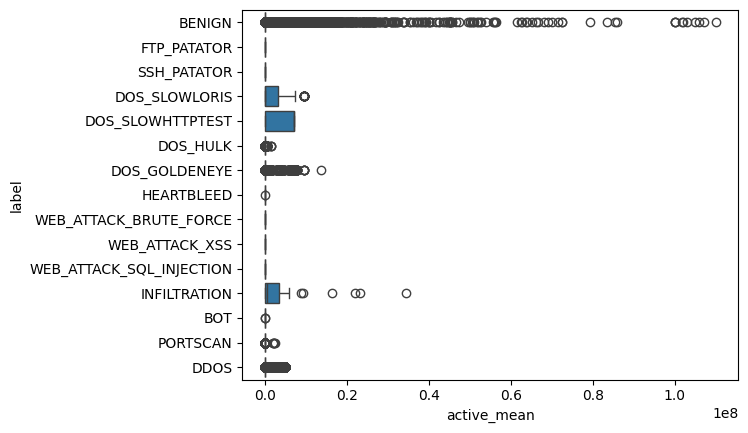

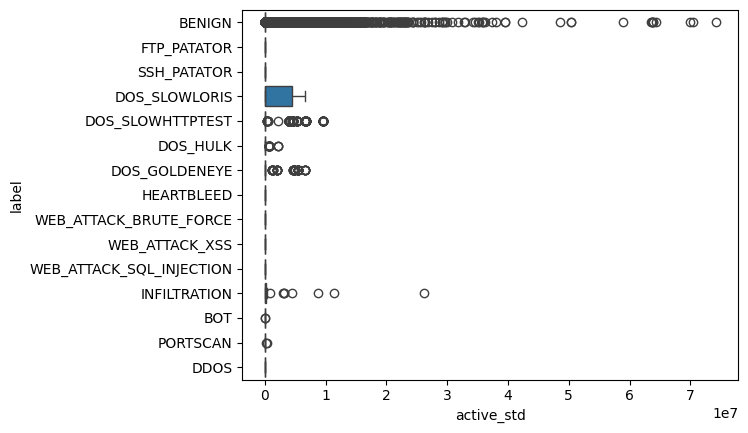

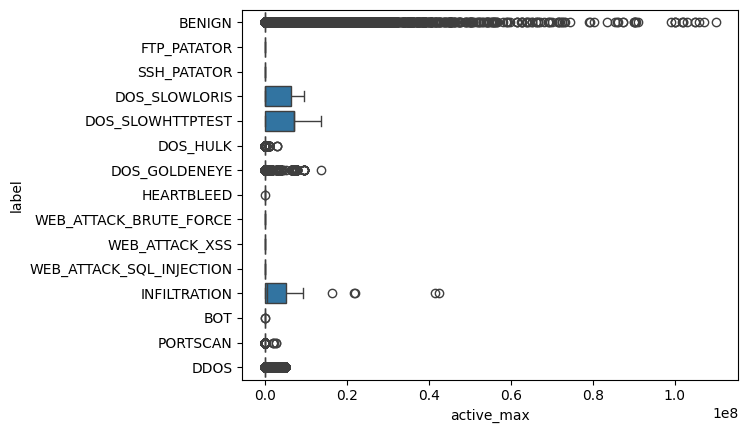

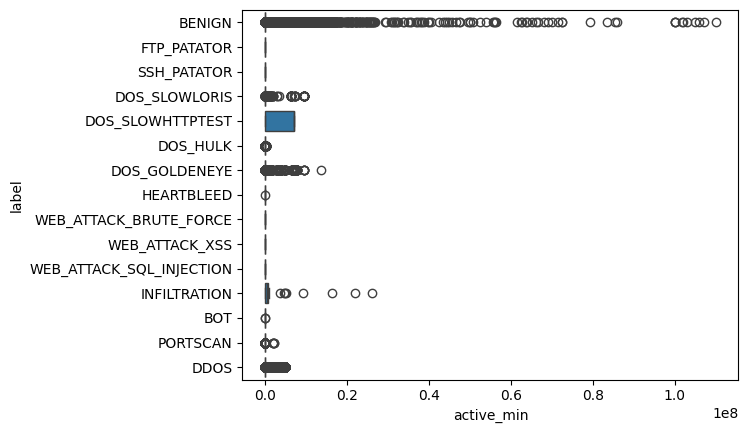

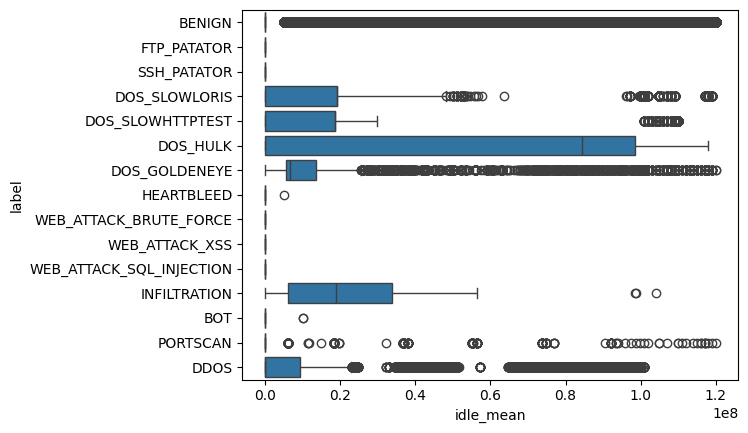

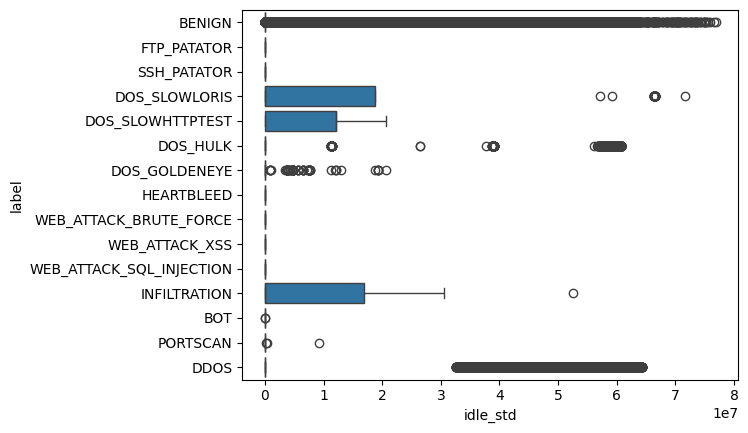

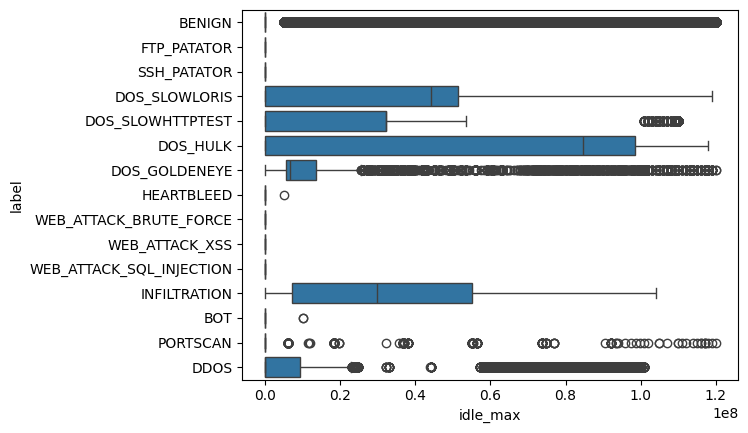

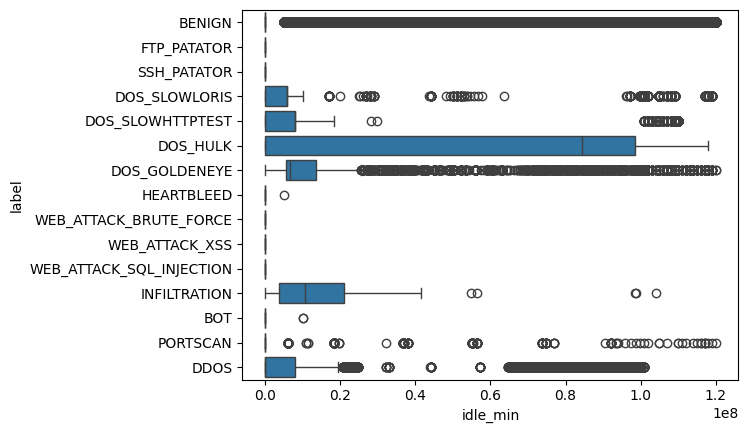

In [10]:
for i in caracteristicas_numericas : 
  sns.boxplot(x=i, y='label', data=df)

  plt.xlabel(i)
  plt.ylabel("label")
  plt.show()

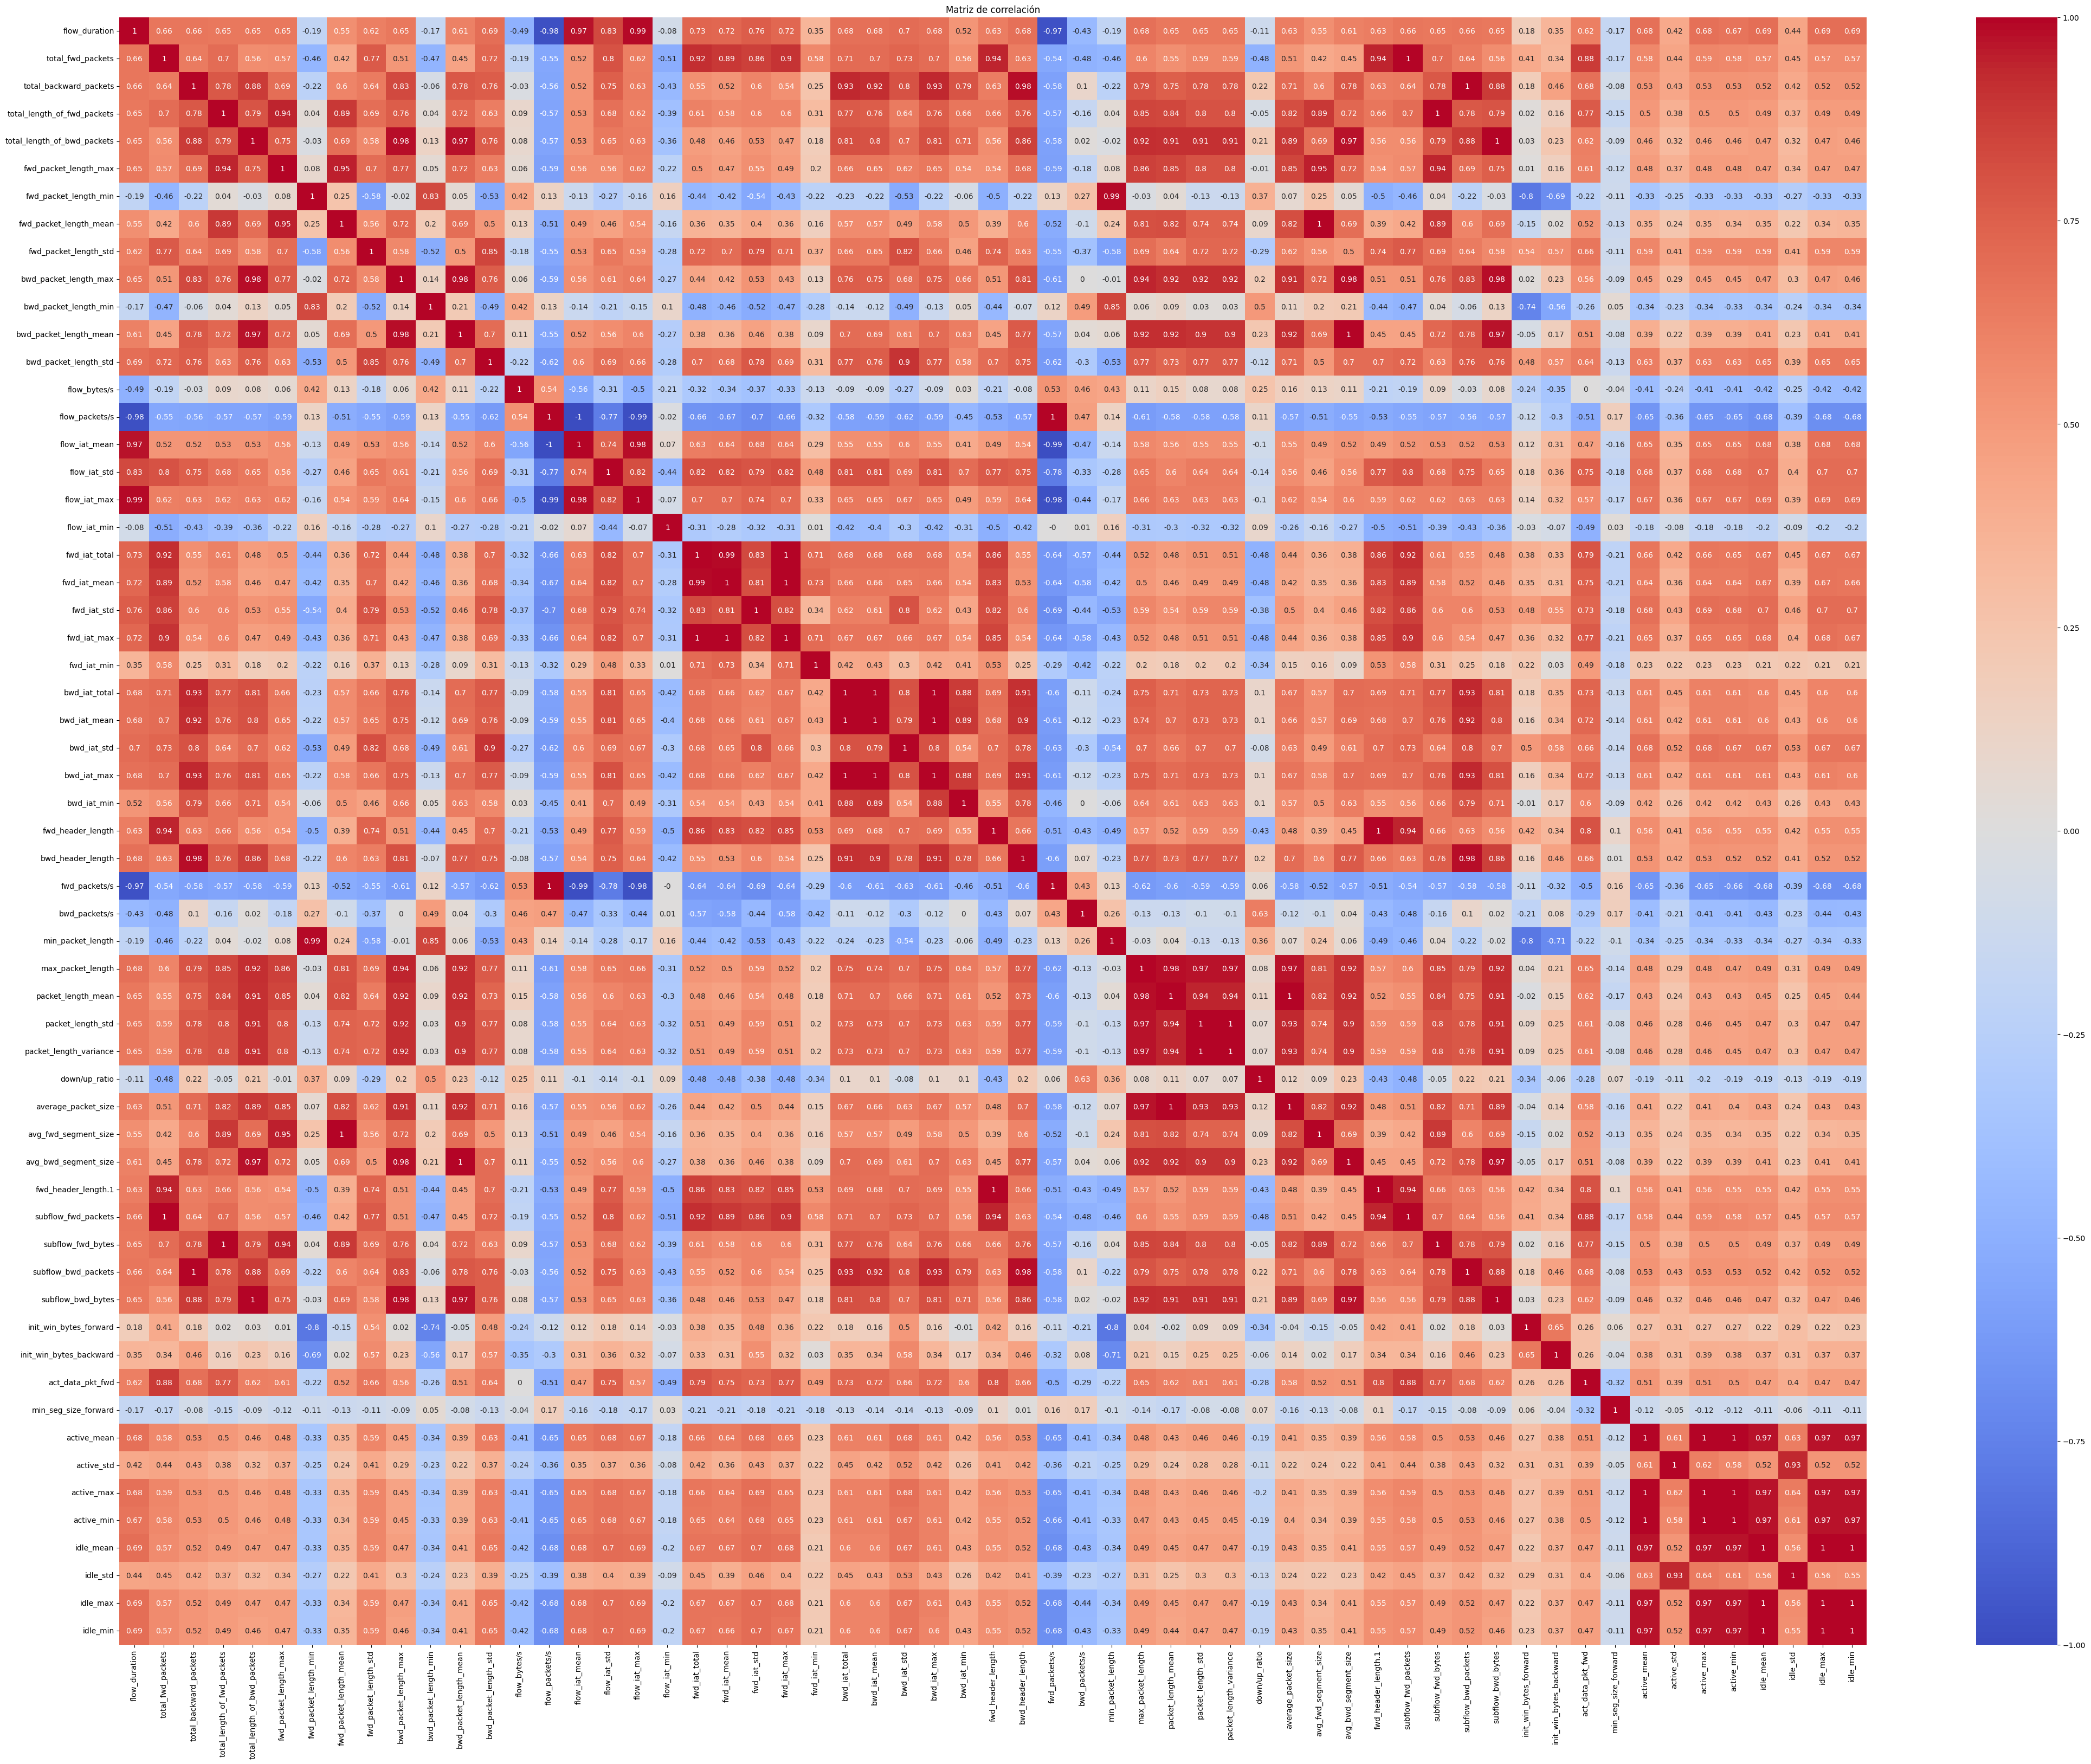

In [9]:
# Matriz de correlación con test de correlación de Spearman
matriz_correlacion = df.drop(caracteristicas_nominales + caracteristicas_binarias + caracteristicas_no_utiles, axis=1).corr(method="spearman").round(decimals=2)

# Generar gráfico de mapa de calor para observar la correlación 
plt.figure(figsize=(52, 39))

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de correlación")
plt.savefig("img/matriz_correlacion_pearson_no_normalizada.png")
plt.show()

## Verificación de calidad de datos

### 1. Revisión de datos nulos

Como se puede observar, la característica Flow Bytes/s presenta valores nulos, por ello, se implementará una técnica de imputación de valores faltantes en el dataset

In [16]:
df.isnull().sum().head(40)

destination_port                  0
flow_duration                     0
total_fwd_packets                 0
total_backward_packets            0
total_length_of_fwd_packets       0
total_length_of_bwd_packets       0
fwd_packet_length_max             0
fwd_packet_length_min             0
fwd_packet_length_mean            0
fwd_packet_length_std             0
bwd_packet_length_max             0
bwd_packet_length_min             0
bwd_packet_length_mean            0
bwd_packet_length_std             0
flow_bytes/s                   1358
flow_packets/s                    0
flow_iat_mean                     0
flow_iat_std                      0
flow_iat_max                      0
flow_iat_min                      0
fwd_iat_total                     0
fwd_iat_mean                      0
fwd_iat_std                       0
fwd_iat_max                       0
fwd_iat_min                       0
bwd_iat_total                     0
bwd_iat_mean                      0
bwd_iat_std                 

In [17]:
df.isnull().sum().tail(40)

max_packet_length          0
packet_length_mean         0
packet_length_std          0
packet_length_variance     0
fin_flag_count             0
syn_flag_count             0
rst_flag_count             0
psh_flag_count             0
ack_flag_count             0
urg_flag_count             0
cwe_flag_count             0
ece_flag_count             0
down/up_ratio              0
average_packet_size        0
avg_fwd_segment_size       0
avg_bwd_segment_size       0
fwd_header_length.1        0
fwd_avg_bytes/bulk         0
fwd_avg_packets/bulk       0
fwd_avg_bulk_rate          0
bwd_avg_bytes/bulk         0
bwd_avg_packets/bulk       0
bwd_avg_bulk_rate          0
subflow_fwd_packets        0
subflow_fwd_bytes          0
subflow_bwd_packets        0
subflow_bwd_bytes          0
init_win_bytes_forward     0
init_win_bytes_backward    0
act_data_pkt_fwd           0
min_seg_size_forward       0
active_mean                0
active_std                 0
active_max                 0
active_min    

Revisamos con que etiquetas está relacionado en la columna label

In [18]:
df[df["flow_bytes/s"].isnull()]["label"].unique()

array(['BENIGN', 'DOS_HULK'], dtype=object)

In [19]:
print(f"Valores faltantes en DOS_HULK: {df[df["label"] == "DOS_HULK"]["flow_bytes/s"].isnull().sum()}")
print(F"Valores faltantes en BENIGN: {df[df["label"] == "BENIGN"]["flow_bytes/s"].isnull().sum()}")

Valores faltantes en DOS_HULK: 949
Valores faltantes en BENIGN: 409


Imputamos los datos con la mediana del dataset

In [20]:
imputacion_con_filtro = False

if imputacion_con_filtro :
  # Cálculo de medianas de etiquetas de la característica Flow Bytes/s filtrando por la variable objetivo 
  mediana_dos_hulk = df[df[" Label"] == "DoS Hulk"]["Flow Bytes/s"].median()
  mediana_benign   = df[df[" Label"] == "BENIGN"]["Flow Bytes/s"].median()  
  print(f"""
Mediana de la característica Flow Bytes/s en la etiqueta DOS Hulk: {mediana_dos_hulk}
Mediana de la característica Flow Bytes/s en la etiqueta BENIGN: {mediana_benign}
  """)
  df.loc[df["Flow Bytes/s"].isnull() & (df[" Label"] == "DoS Hulk"), "Flow Bytes/s"] = mediana_dos_hulk
  df.loc[df["Flow Bytes/s"].isnull() & (df[" Label"] == "BENIGN"), "Flow Bytes/s"] = mediana_benign
else : 
  mediana = df["Flow Bytes/s"].median()
  print(f"Mediana de la característica Flow Bytes/s: {mediana}\n")
  df["flow_bytes/s"] = df["flow_bytes/s"].fillna(mediana)

print(f"Valores faltantes en DOS_HULK: {df[df[" Label"] == "DoS Hulk"]["Flow Bytes/s"].isnull().sum()}")
print(F"Valores faltantes en BENIGN: {df[df[" Label"] == "BENIGN"]["Flow Bytes/s"].isnull().sum()}")

KeyError: 'Flow Bytes/s'

### 2. Revisión de datos infinitos

Asimismo, existen dos columnas que tienen valores que tienden a infinito, la información en este formato no es útil para el modelo, por ello, se aplicará una estrategia para resolver dicha problemática

In [ ]:
# Revisión de valores infinito en el dataset
for i in caracteristicas_numericas + caracteristicas_con_valor_maximo_infinito : 
  cant_inf = df[np.isinf(df[i])].shape[0]
  print(f"Característica: {i} - cant. inf. {cant_inf}")

Característica: flow_duration - cant. inf. 0
Característica: total_fwd_packets - cant. inf. 0
Característica: total_backward_packets - cant. inf. 0
Característica: total_length_of_fwd_packets - cant. inf. 0
Característica: total_length_of_bwd_packets - cant. inf. 0
Característica: fwd_packet_length_max - cant. inf. 0
Característica: fwd_packet_length_min - cant. inf. 0
Característica: fwd_packet_length_mean - cant. inf. 0
Característica: fwd_packet_length_std - cant. inf. 0
Característica: bwd_packet_length_max - cant. inf. 0
Característica: bwd_packet_length_min - cant. inf. 0
Característica: bwd_packet_length_mean - cant. inf. 0
Característica: bwd_packet_length_std - cant. inf. 0
Característica: flow_iat_mean - cant. inf. 0
Característica: flow_iat_std - cant. inf. 0
Característica: flow_iat_max - cant. inf. 0
Característica: flow_iat_min - cant. inf. 0
Característica: fwd_iat_total - cant. inf. 0
Característica: fwd_iat_mean - cant. inf. 0
Característica: fwd_iat_std - cant. inf. 0

La característica bwd_packets/s parece estar influenciada por las columnas fwd_packets/s y bwd_packets/s, a continuación, se verificará eso

In [ ]:
# Verificación de valores con la función np.isclose, en casos donde existen bastantes decimales en un dato, es útil para verificar si el valor se aproxima al otro
df["resultado"] = np.isclose(df["bwd_packets/s"] + df["fwd_packets/s"], df["flow_packets/s"])
df["resultado"].value_counts()

resultado
True     2827761
False       2982
Name: count, dtype: int64

En total, solo existen 2982 valores de la columna flow_packets/s que no coinciden con la suma de las columnas bwd_packets/s y fwd_packets/s, hay que considerar que dentro de estas columnas están contenidos los valores de infinito, a continuación, extraeremos los valores en un dataframe nuevo

In [ ]:
df_pruebita = df[~df["resultado"]]
df_pruebita.shape

(2982, 80)

En total, solo hay 115 registros que no coinciden con la columna flow_packets/s y no pertenecen a infinito, se verán que valores tienen, asimismo, a que etiquetas de la variable objetivo corresponden

In [ ]:
df_pruebita = df_pruebita[~np.isinf(df_pruebita["flow_packets/s"])]
df_pruebita.shape

(115, 80)

In [ ]:
df_pruebita["pruebita2"] = (df_pruebita["fwd_packets/s"] + df_pruebita["bwd_packets/s"]) - df_pruebita["flow_packets/s"] 
df_pruebita["pruebita2"].unique()

array([2000000.    ,  500000.    , 1000000.    ,  166666.6667,
        153846.1538])

In [ ]:
df_pruebita["label"].unique()

array(['BENIGN'], dtype=object)

Ahora, se revisará que valores tienen los datos que son infinito en la columna flow_packets/s, esto nos permitirá definir que valor otorgar a esta columna.

Como se puede observar, la columna flow_packets/s tiene como valores 0

In [ ]:
df_pruebita = df[~df["resultado"]]
df_pruebita.shape
df_pruebita = df_pruebita[np.isinf(df_pruebita["flow_packets/s"])]
df_pruebita.shape

(2867, 80)

In [ ]:
df_pruebita["pruebita2"] = df_pruebita["fwd_packets/s"] + df_pruebita["bwd_packets/s"]
df_pruebita["pruebita2"].unique()

array([0.])

In [ ]:
df_pruebita["fwd_packets/s"].describe()

count    115.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: fwd_packets/s, dtype: float64

In [ ]:
df_pruebita["bwd_packets/s"].describe()

count    2867.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: bwd_packets/s, dtype: float64

Revisamos con que etiquetas está relacionado en la columna label

In [ ]:
df[np.isinf(df["flow_bytes/s"])]["label"].unique()

array(['BENIGN', 'FTP_PATATOR', 'BOT', 'PORTSCAN', 'DDOS'], dtype=object)

In [ ]:
df[np.isinf(df["flow_packets/s"])]["label"].unique()

array(['BENIGN', 'FTP_PATATOR', 'DOS_HULK', 'BOT', 'PORTSCAN', 'DDOS'],
      dtype=object)

Imputamos los datos con valor máximo infinito con el valor antes de infinito

In [ ]:
df["flow_bytes/s"] = df["flow_bytes/s"].replace(np.inf, np.nan)
print(df["flow_bytes/s"].max())
df["flow_bytes/s"] = df["flow_bytes/s"].fillna(df["flow_bytes/s"].max())

2071000000.0


In [ ]:
df["flow_packets/s"] = df["flow_packets/s"].replace(np.inf, np.nan)
print(df["flow_packets/s"].max())
df["flow_packets/s"] = df["flow_packets/s"].fillna(df["flow_packets/s"].max())

4000000.0


### 3. Revisión de cambios en las características

In [ ]:
# Ahora los datos son más útiles para entrenamiento
for i in caracteristicas_con_valor_maximo_infinito : 
  print(f"""
Característica: {i}
{df[i].describe()}
""")


Característica: flow_bytes/s
count    2.830743e+06
mean     3.587734e+06
std      7.074983e+07
min     -2.610000e+08
25%      1.193427e+02
50%      4.603446e+03
75%      1.666667e+05
max      2.071000e+09
Name: flow_bytes/s, dtype: float64


Característica: flow_packets/s
count    2.830743e+06
mean     7.483370e+04
std      2.833403e+05
min     -2.000000e+06
25%      3.446226e+00
50%      1.106684e+02
75%      2.325581e+04
max      4.000000e+06
Name: flow_packets/s, dtype: float64



### 4. Selección de datos relevantes

Para la selección de características relevantes para la detección de ciberataques, se propone el uso del criterio de impureza de Gini, dicho método está orientado a la reducción de dimensionalidad utilizando un criterio de selección de características basado en la importancia que otorga el criterio de impureza de Gini a las características utilizadas en la investigación.

Estudio de referencia: [Performance analysis of machine learning models for intrusion detection system using Gini Impurity-based Weighted Random Forest (GIWRF) feature selection technique](https://cybersecurity.springeropen.com/articles/10.1186/s42400-021-00103-8)

#### 4.1. Normalización de datos 

In [ ]:
# caracteristicas_nominales
# caracteristicas_binarias
# caracteristicas_numericas 
# caracteristicas_no_utiles 
# caracteristicas_con_valor_maximo_infinito

# Creación de Dataframe con variables continuas normalizadas
df_normalizado = df[caracteristicas_nominales + caracteristicas_binarias].copy()

for i in caracteristicas_numericas + caracteristicas_con_valor_maximo_infinito : 
  df_normalizado[f"{i}_normalized"] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())
  print(f"""
Característica: {i}_normalized
{df_normalizado[f"{i}_normalized"].describe()}
""")


Característica: flow_duration_normalized
count    2.830743e+06
mean     1.232140e-01
std      2.804478e-01
min      0.000000e+00
25%      1.400000e-06
50%      2.610750e-04
75%      2.670701e-02
max      1.000000e+00
Name: flow_duration_normalized, dtype: float64


Característica: total_fwd_packets_normalized
count    2.830743e+06
mean     3.804712e-05
std      3.411356e-03
min      0.000000e+00
25%      4.550460e-06
50%      4.550460e-06
75%      1.820184e-05
max      1.000000e+00
Name: total_fwd_packets_normalized, dtype: float64


Característica: total_backward_packets_normalized
count    2.830743e+06
mean     3.560461e-05
std      3.416626e-03
min      0.000000e+00
25%      3.425573e-06
50%      6.851145e-06
75%      1.370229e-05
max      1.000000e+00
Name: total_backward_packets_normalized, dtype: float64


Característica: total_length_of_fwd_packets_normalized
count    2.830743e+06
mean     4.258158e-05
std      7.746968e-04
min      0.000000e+00
25%      9.302326e-07
50%      4

#### 4.2. Preparación de datos

In [ ]:
X_columns = df_normalizado.drop(["label"], axis=1).columns
y_columns = "label"
X = df_normalizado.drop(["label"], axis=1)
y = df_normalizado[["label"]]

In [ ]:
generar_muestra = True
if (generar_muestra) :
  X_vector, X_resto, y_vector, y_resto = train_test_split(X, y, test_size= 1 - proporcion_muestra, random_state=seed, stratify=y)

  print("Dataset de muestra")
  obtenerFrecuencia(y_vector)
  print(f"Total: {y_vector.shape[0]}")

  # El dataset de muestra no contiene suficiente información sobre los ciberataques WEB_ATTACK_XSS, INFILTRATION, WEB_ATTACK_SQL_INJECTION y HEARTBLEED

  etiquetas_label_a_conservar = ["BENIGN","DOS_HULK","PORTSCAN","DDOS","DOS_GOLDENEYE","FTP_PATATOR","SSH_PATATOR","DOS_SLOWLORIS","DOS_SLOWHTTPTEST","BOT","WEB_ATTACK_BRUTE_FORCE"]

  X_vector = X_vector[y_vector["label"].isin(etiquetas_label_a_conservar)]
  y_vector = y_vector[y_vector["label"].isin(etiquetas_label_a_conservar)]

  X_train, X_test, y_train, y_test = train_test_split(X_vector, y_vector, test_size=0.2, random_state=seed, stratify=y_vector)
else : 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

Dataset de muestra
                          Frecuencia  Porcentaje
label                                           
BENIGN                        142026   80.300563
DOS_HULK                       14438    8.163150
PORTSCAN                        9930    5.614356
DDOS                            7999    4.522582
DOS_GOLDENEYE                    643    0.363548
FTP_PATATOR                      496    0.280435
SSH_PATATOR                      368    0.208065
DOS_SLOWLORIS                    362    0.204672
DOS_SLOWHTTPTEST                 344    0.194495
BOT                              123    0.069543
WEB_ATTACK_BRUTE_FORCE            94    0.053147
WEB_ATTACK_XSS                    41    0.023181
INFILTRATION                       2    0.001131
WEB_ATTACK_SQL_INJECTION           1    0.000565
HEARTBLEED                         1    0.000565
Total: 176868


In [ ]:
# Observación defrecuencias en los datasets de entrenamiento y pruebas

print("Dataset de entrenamiento")
obtenerFrecuencia(y_train)
print(f"Total: {y_train.shape[0]}")

print("Dataset de prueba")
obtenerFrecuencia(y_test)
print(f"Total: {y_test.shape[0]}")

Dataset de entrenamiento
                        Frecuencia  Porcentaje
label                                         
BENIGN                      113621   80.321367
DOS_HULK                     11550    8.164968
PORTSCAN                      7944    5.615801
DDOS                          6399    4.523604
DOS_GOLDENEYE                  514    0.363359
FTP_PATATOR                    397    0.280649
SSH_PATATOR                    294    0.207836
DOS_SLOWLORIS                  290    0.205008
DOS_SLOWHTTPTEST               275    0.194404
BOT                             99    0.069985
WEB_ATTACK_BRUTE_FORCE          75    0.053019
Total: 141458
Dataset de prueba
                        Frecuencia  Porcentaje
label                                         
BENIGN                       28405   80.319525
DOS_HULK                      2888    8.166266
PORTSCAN                      1986    5.615722
DDOS                          1600    4.524247
DOS_GOLDENEYE                  129    0.364767
FTP

Conversión a array de numpy

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train["label"].to_numpy()
X_test = X_test.to_numpy()
y_test = y_test["label"].to_numpy()

#### 4.3. Creación y entrenamiento del modelo

In [ ]:
# Creación del modelo con RandomForestClassifier
rf_clf = RandomForestClassifier(
  random_state=seed,
  n_estimators=100
)

In [ ]:
# Entrenamiento del modelo
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=9603)

#### 4.4. Validación del modelo

In [ ]:
y_pred = rf_clf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[28390     2     0     1     4     1     0     0     7     0     0]
 [   11    13     0     0     0     0     0     0     0     0     0]
 [    2     0  1598     0     0     0     0     0     0     0     0]
 [   10     0     0   119     0     0     0     0     0     0     0]
 [   17     0     0     0  2870     0     0     0     1     0     0]
 [    2     0     0     0     0    67     0     0     0     0     0]
 [    0     0     0     0     0     0    72     0     0     0     0]
 [    0     0     0     0     0     0     0    99     0     0     0]
 [    5     0     0     0     2     0     0     0  1979     0     0]
 [    4     0     0     0     0     0     0     0     0    70     0]
 [    3     0     0     0     0     0     0     0     0     0    16]]


In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

                        precision    recall  f1-score   support

                BENIGN       1.00      1.00      1.00     28405
                   BOT       0.87      0.54      0.67        24
                  DDOS       1.00      1.00      1.00      1600
         DOS_GOLDENEYE       0.99      0.92      0.96       129
              DOS_HULK       1.00      0.99      1.00      2888
      DOS_SLOWHTTPTEST       0.99      0.97      0.98        69
         DOS_SLOWLORIS       1.00      1.00      1.00        72
           FTP_PATATOR       1.00      1.00      1.00        99
              PORTSCAN       1.00      1.00      1.00      1986
           SSH_PATATOR       1.00      0.95      0.97        74
WEB_ATTACK_BRUTE_FORCE       1.00      0.84      0.91        19

              accuracy                           1.00     35365
             macro avg       0.99      0.93      0.95     35365
          weighted avg       1.00      1.00      1.00     35365



#### 4.5. Visualización de importancia otorgada por el modelo

In [ ]:
importancias = rf_clf.feature_importances_
df_importancias = pd.DataFrame({
  "Característica": X_columns,
  "Importancia": importancias * 100
}).sort_values(by="Importancia", ascending=False)


In [ ]:
df_importancias.shape

(70, 2)

In [ ]:
df_importancias.tail(40)

Característica  Importancia
11           flow_duration_normalized     1.243200
24           flow_iat_mean_normalized     1.151748
31             fwd_iat_max_normalized     1.148993
32             fwd_iat_min_normalized     1.128960
7                      ack_flag_count     1.048973
29            fwd_iat_mean_normalized     1.045034
28           fwd_iat_total_normalized     0.996905
64               idle_mean_normalized     0.964108
54     subflow_bwd_packets_normalized     0.928924
19   fwd_packet_length_std_normalized     0.884963
13  total_backward_packets_normalized     0.836516
40           fwd_packets/s_normalized     0.787824
59    min_seg_size_forward_normalized     0.720302
27            flow_iat_min_normalized     0.696593
42       min_packet_length_normalized     0.547128
33           bwd_iat_total_normalized     0.481362
17   fwd_packet_length_min_normalized     0.344359
34            bwd_iat_mean_normalized     0.320595
39       bwd_header_length_normalized     0.318428
37             bwd_iat_min_normalized     0.287131
36             bwd_iat_max_normalized     0.227526
8                      urg_flag_count     0.208684
62              active_max_normalized     0.168903
35             bwd_iat_std_normalized     0.161137
47           down/up_ratio_normalized     0.139136
60             active_mean_normalized     0.137082
3                      fin_flag_count     0.133870
63              active_min_normalized     0.126733
4                      syn_flag_count     0.119906
61              active_std_normalized     0.069813
65                idle_std_normalized     0.064487
1                       fwd_psh_flags     0.049774
51     fwd_header_length.1_normalized     0.044412
38       fwd_header_length_normalized     0.003602
9                      cwe_flag_count     0.001159
2                       fwd_urg_flags     0.001132
10                     ece_flag_count     0.000082
5                      rst_flag_count     0.000000
68            flow_bytes/s_normalized     0.000000
69          flow_packets/s_normalized     0.000000

### 5. Matriz de correlación

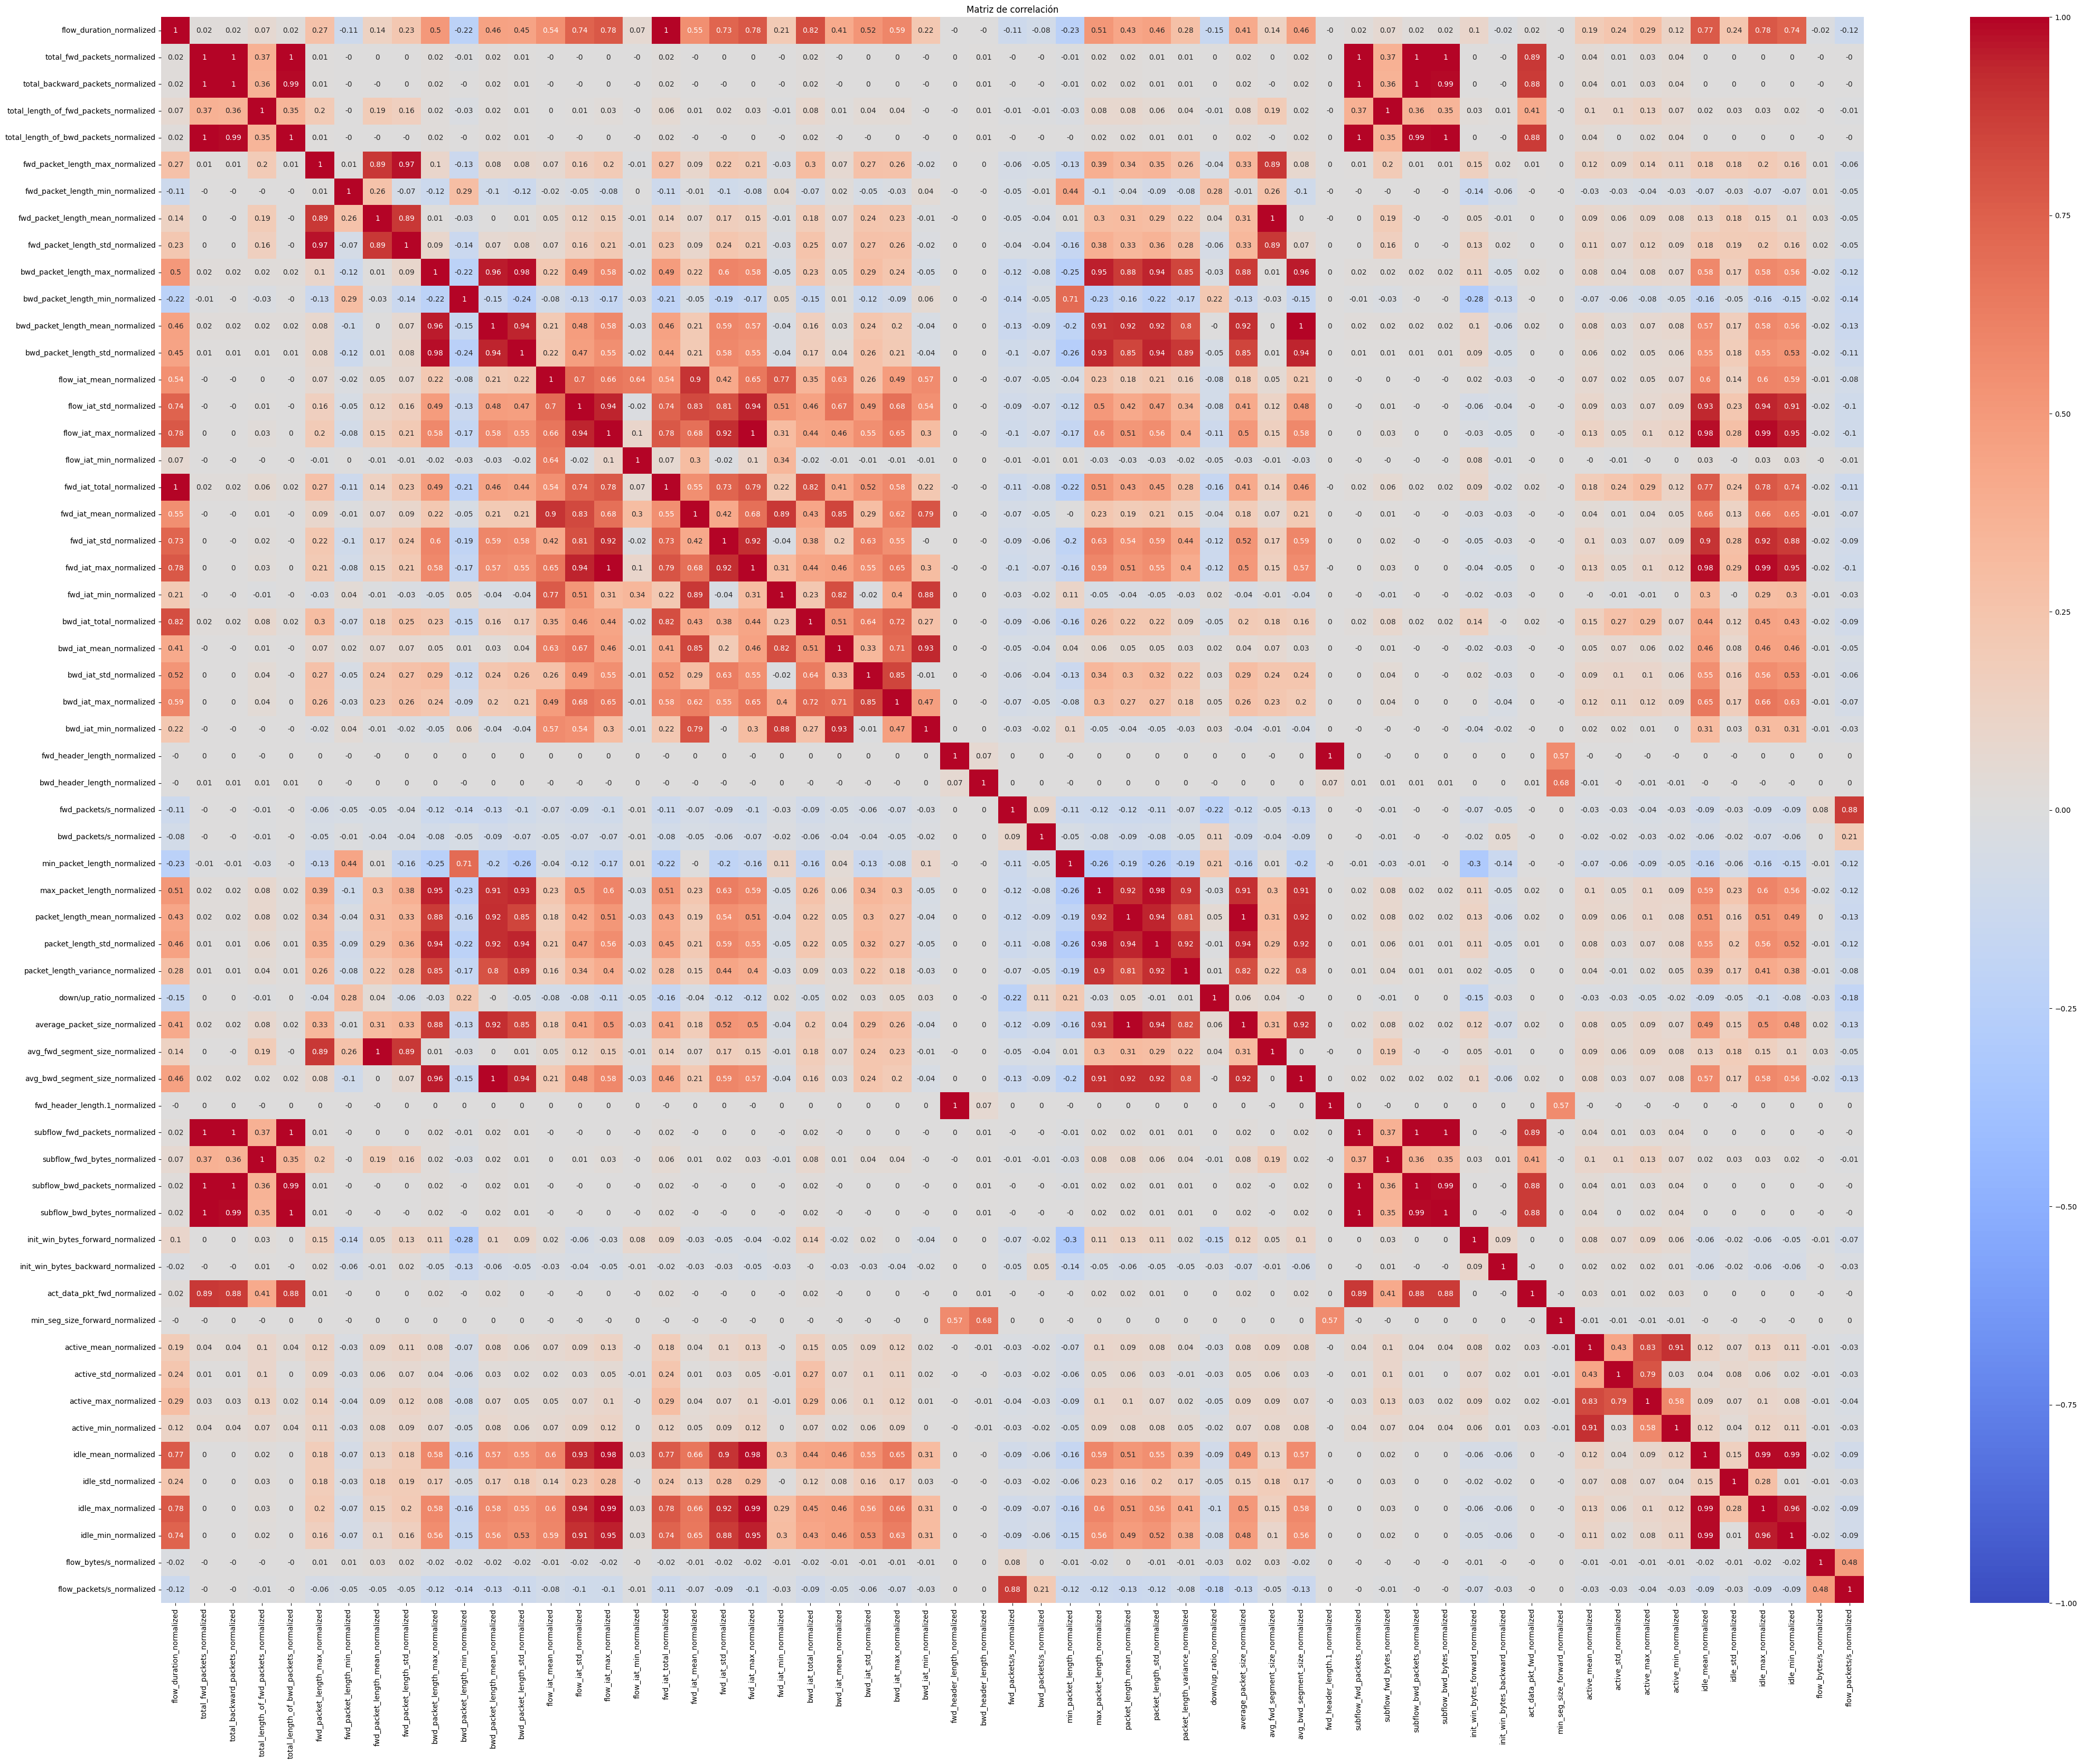

In [ ]:
matriz_correlacion = df_normalizado.drop(caracteristicas_nominales + caracteristicas_binarias, axis=1).corr().round(decimals=2)

# Generar gráfico de mapa de calor para observar la correlación 
plt.figure(figsize=(52, 39))

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de correlación")
plt.savefig("img/matriz_correlacion_normalizado.png")
plt.show()

# Por pasar

#### 2.3. Variables continuas

##### Histograma y boxplot de variables continuas

In [ ]:
for i in caracteristicas_vmax_inf : 

  df.boxplot(column=i, vert=False)
  plt.title(f"Diagrama de caja de {i}")
  plt.show()

### 3. Resumen de tipos de variables del dataset

In [ ]:
print(f"""
Características que no son útiles para el análisis
{caracteristicas_sin_evaluación}
Cantidad: {len(caracteristicas_sin_evaluación)}

Características continuas: 
  {caracteristicas_numericas}
  Cantidad: {len(caracteristicas_numericas)}
  Tienen un valor máximo no apto para entrenar modelos: 
  {caracteristicas_vmax_inf}
  Cantidad: {len(caracteristicas_vmax_inf)}
  
Características categóricas:
  Binarias: 
  {caracteristicas_categoricas_binarias}
  Cantidad: {len(caracteristicas_categoricas_binarias)}
  Nominales: 
  {caracteristicas_categoricas_nominales}
  Cantidad: {len(caracteristicas_categoricas_nominales)}
""")

#### 4.3. Boxplots

In [ ]:

for i in df_normalizado.drop(columns=["destination_port", "label"], axis=1).columns : 
    sns.boxplot(x=i, y='label', data=df_normalizado)

    plt.xlabel(i)
    plt.ylabel("label")
    plt.show()